In [32]:
import sys
sys.path.append("..")
from IPython.display import display

In [725]:
import numpy as np
import logging
import pickle

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)

#### Load a Jet Dictionary

In [392]:
 #-------------------------
# Load a jet
# input_jet = 'antikt_tree_18_truth_-1'
input_jet = 'tree_19_truth'
input_dir= 'data/'

fd = open(input_dir+ str(input_jet) + '.pkl', "rb")
jet_dic = pickle.load(fd, encoding='latin-1')
# X= pickle.load(fd,encoding='latin-1')
fd.close()

print('jet dictionary =',jet_dic)

jet dictionary = {'root_id': 0, 'tree': array([[ 1, 12],
       [ 2,  9],
       [ 3,  6],
       [ 4,  5],
       [-1, -1],
       [-1, -1],
       [ 7,  8],
       [-1, -1],
       [-1, -1],
       [10, 11],
       [-1, -1],
       [-1, -1],
       [13, 14],
       [-1, -1],
       [-1, -1]]), 'content': array([[300.        , 500.        ],
       [183.54258728, 228.20791626],
       [103.62121582, 102.0807724 ],
       [ 57.35109711,  56.94499969],
       [ 28.28836441,  26.69569778],
       [ 29.0627327 ,  30.24930191],
       [ 46.27011871,  45.13577271],
       [ 24.5510025 ,  23.33363342],
       [ 21.71911621,  21.80213928],
       [ 79.92137146, 126.12714386],
       [ 39.31695557,  64.10958099],
       [ 40.60441589,  62.01755905],
       [116.45741272, 271.79208374],
       [ 51.43334961, 133.29421997],
       [ 65.02406311, 138.49786377]]), 'Lambda': 8, 'Delta_0': tensor([100.]), 'pt_cut': 1.0, 'M_Hard': 80.0, 'deltas': ['Mw', tensor([16.8813]), tensor([8.0970]), tensor([1.

In [394]:
# input_jet='tree_13_truth'
# node_id_antikt, linkage_list_antikt, Nconst_antikt, tree_ancestors_antikt = recluster(input_jet, alpha=-1)

### Traverse a jet from reading its tree history (from root to leaves)

In [811]:
# from collections import OrderedDict
def traverse_jet(jet, parent=None, node_id=None, outers_list=None, dendrogram=True, 
                 ancestors=None, tree_ancestors=[], parent_child_dic=None, outers_node_id=None):
    '''
    Recursive function to traverse the tree and get a list of the leaves 
    Args:
        jet: jet dictionary
        node_id: id of the current node
        outers_list: list that stores the momentum of the leaves
    
    Returns:
        outers_list
    '''
    new_ancestors=None
    if dendrogram:
        new_ancestors=np.copy(ancestors)
#         print(' ancestors before=', ancestors)
#         new_ancestors = np.append(new_ancestors,id) # Node ids in terms of the reclustered jet dictionary
        new_ancestors = np.append(new_ancestors,node_id) # Node ids in terms of the truth jet dictionary
    
    
    if jet["tree"][node_id, 0] == -1:
        outers_list.append(jet["content"][node_id])
        outers_node_id.append(node_id)
        
        if dendrogram:
            tree_ancestors.append(new_ancestors)
#             print('tree_ancestors=', tree_ancestors)
        
        
    else:
        parent_child_dic[node_id]=jet["tree"][node_id]
#         parent_child_dic.append([node_id,jet["tree"][node_id]])
        
        traverse_jet(jet, node_id, jet["tree"][node_id, 0],outers_list, ancestors=new_ancestors, dendrogram=dendrogram, 
                     tree_ancestors=tree_ancestors, parent_child_dic=parent_child_dic, outers_node_id=outers_node_id)
        
        traverse_jet(jet, node_id, jet["tree"][node_id, 1],outers_list, ancestors=new_ancestors, dendrogram=dendrogram, 
                     tree_ancestors=tree_ancestors, parent_child_dic=parent_child_dic, outers_node_id=outers_node_id)

        
        

        
        
    return outers_list, tree_ancestors, parent_child_dic, outers_node_id

In [920]:
def runTraverse_jet(in_jet, parent=-1, node_id=0, dendrogram=True, 
                 ancestors=[], tree_ancestors=[],draw_tree=False):
    
    
    input_dir= 'data/'

    fd = open(input_dir+ str(in_jet) + '.pkl', "rb")
    jet = pickle.load(fd, encoding='latin-1')
    # X= pickle.load(fd,encoding='latin-1')
    fd.close()

#     print('jet dictionary =',jet_dic)

    parent_child_dic={}
    tree_ancestors=[]
    outers_list=[]
    outers_node_id=[]
    
    node_id =  jet['root_id']
    
    outers_list, tree_ancestors, parent_child, outers_node_id = traverse_jet(jet, parent=parent, node_id=node_id, outers_list=outers_list, 
                                                             dendrogram=dendrogram, ancestors=ancestors, tree_ancestors=tree_ancestors, 
                                                             parent_child_dic=parent_child_dic, outers_node_id=outers_node_id)
    
#     print('len(outers_list) =', len(outers_list))
    
    if draw_tree:
        return outers_list, tree_ancestors, parent_child, outers_node_id
    
    else:
        return outers_list, tree_ancestors


In [782]:
temp_outers_list, temp_tree_ancestors = runTraverse_jet('tree_31_truth')


len(outers_list) = 51


In [751]:
# temp_outers_list

In [783]:
np.sum(np.sum(np.array(temp_outers_list) < 0, axis=1))

0

In [921]:
def draw_truth(in_jet):

    outers_list, tree_ancestors, parent_children, outers_node_id = runTraverse_jet(in_jet, draw_tree=True)

    N=outers_node_id[-1]
    Nleaves=len(outers_node_id)
    const_list=np.arange(Nleaves)
    temp_outers_node_id=outers_node_id
    idx=np.asarray(outers_node_id)
    temp=[]
    sibling_pairs=np.asarray(list(parent_children.values()))[::-1]
    # for i,k in enumerate(outers_node_id[::-1]):
    N_leaves_list = np.ones((Nleaves))
    linkage_list=[]
    waitlist={}
    j=0
    m=0
    for i in range(N,0,-1):  
        m+=1
#         print('---'*5)
#         print(i)

    #     node_pos=np.where(idx==i)  

        node=np.where(sibling_pairs==i)
        sibling=sibling_pairs[node[0],1-node[1]]   
#         print('node =', node)
#         print('sibling = ', sibling)


        node_pos=None
#         print('temp_outers_node_id=',temp_outers_node_id)

        if i in temp_outers_node_id:
            node_pos=np.where(idx==i)[0][0]
            temp_outers_node_id = np.delete(temp_outers_node_id,node_pos)

        else:
            const_list = np.append(const_list,Nleaves+j)
            node_pos=Nleaves+j
            j+=1
    #     elif i in waitlist.keys():
    #         node_pos = waitlist[i]

        if node_pos!=None:
#             print('node_pos=',node_pos)

            if sibling[0] in temp_outers_node_id:
                sibling_pos=np.where(idx==sibling[0])
                N_leaves_list = np.append(N_leaves_list, N_leaves_list[node_pos]+N_leaves_list[sibling_pos[0]])
                linkage_list.append([np.minimum(const_list[node_pos],const_list[sibling_pos[0]][0]),
                                     np.maximum(const_list[node_pos],const_list[sibling_pos[0]][0]),m,N_leaves_list[-1]])

            elif sibling[0] in waitlist.keys():
                N_leaves_list = np.append(N_leaves_list, N_leaves_list[node_pos]+N_leaves_list[waitlist[sibling[0]]])
                linkage_list.append([np.minimum(const_list[node_pos],const_list[waitlist[sibling[0]]]),
                                     np.maximum(const_list[node_pos],const_list[waitlist[sibling[0]]]),m,N_leaves_list[-1]])

            else:
                waitlist[i]=node_pos

#             print('linkage_list = ', linkage_list)

    #     print('waitlist =',waitlist)
    return np.asarray(linkage_list)   

In [922]:
linkage_list_truth = draw_truth('tree_19_truth')

In [923]:
linkage_list_truth

array([[ 6.,  7.,  1.,  2.],
       [ 4.,  5.,  4.,  2.],
       [ 2.,  3.,  7.,  2.],
       [ 0.,  1., 10.,  2.],
       [10., 11., 12.,  4.],
       [ 9., 12., 13.,  6.],
       [ 8., 13., 14.,  8.]])

In [792]:
input_jet='tree_19_truth'
fd = open('data/'+str(input_jet)+'.pkl', "rb")
jet_truth= pickle.load(fd,encoding='latin-1')
# X= pickle.load(fd,encoding='latin-1')
fd.close()
jet_truth

{'root_id': 0, 'tree': array([[ 1, 12],
        [ 2,  9],
        [ 3,  6],
        [ 4,  5],
        [-1, -1],
        [-1, -1],
        [ 7,  8],
        [-1, -1],
        [-1, -1],
        [10, 11],
        [-1, -1],
        [-1, -1],
        [13, 14],
        [-1, -1],
        [-1, -1]]), 'content': array([[300.        , 500.        ],
        [183.54258728, 228.20791626],
        [103.62121582, 102.0807724 ],
        [ 57.35109711,  56.94499969],
        [ 28.28836441,  26.69569778],
        [ 29.0627327 ,  30.24930191],
        [ 46.27011871,  45.13577271],
        [ 24.5510025 ,  23.33363342],
        [ 21.71911621,  21.80213928],
        [ 79.92137146, 126.12714386],
        [ 39.31695557,  64.10958099],
        [ 40.60441589,  62.01755905],
        [116.45741272, 271.79208374],
        [ 51.43334961, 133.29421997],
        [ 65.02406311, 138.49786377]]), 'Lambda': 8, 'Delta_0': tensor([100.]), 'pt_cut': 1.0, 'M_Hard': 80.0, 'deltas': ['Mw',
  tensor([16.8813]),
  tensor([8.097

# kt, CA and anti-kt algorithms for the 1D exponential shower model

In [132]:
import itertools

def dijMinPair(const_list, var_dij_history, tree, jet_content, idx, alpha=None, Nconst=None, Nparent=None, N_leaves_list=None, linkage_list=None):
    '''
    -Calculate all d_ij and get the minimum. 
    -Update the constituents list by deleting the constituents that are merged and adding the new pseudojet 
    
    Note: We refer to both leaves and inner nodes as pseudojets.
    Args:
        - const_list: constituents list for the current level (i.e. deleting the constituents that are merged and 
          adding the new pseudojet in all previous levels)
        - var_dij_history: list of all the previous min{d_ij}
        - tree: dictionary that has the node id of a parent as a key and a list with the id of the 2 children as the values
        - jet_content: array with the momentum of all the nodes of the jet tree (both leaves and inners) after adding one 
          more level in the clustering.
          We add a new node each time we cluster 2 pseudojets
        - idx: array that stores the node id (the node id determines the location of the momentum of a pseudojet in the jet_content array) 
          of the pseudojets that are in the current const_list array. It has the same elements as the const_list (they get updated 
          level by level).
        - alpha: defines the clustering algorithm. alpha={-1,0,1} defines the {anti-kt, CA and kt} algorithms respectively.
        - Nconst: Number of leaves
        - Nparent: index of each parent added to the tree.
        
    Returns:
        -new_list: new const_list after deleting the constituents that are merged and adding the new pseudojet in the current level.
        -var_dij_history
        - tree
        - idx 
        - jet_content
    
    '''    
#     
    pairs = np.asarray(list(itertools.combinations(np.arange(len(const_list)),2)))
    
#     print('Const list all=', const_list)
    const_list_pt=np.absolute([element[0] for element in const_list] )
#     print('const_list_pt =', const_list_pt)
#     print('const_list_pt[pairs] =',const_list_pt[pairs])
    
#     print('Calculating theta')
#     print('const_list_[pairs] =',const_list[pairs])

#     print('----'*3)
#     k=0
#     print(const_list[pairs][k][0])
#     print(const_list[pairs][k][1])
#     print(const_list[pairs][k][0]*const_list[pairs][0][1])
#     print(np.sum(const_list[pairs][k][0]*const_list[pairs][k][1]))
#     print(np.sqrt(np.sum(const_list[pairs][k][0]**2)))
#     print(' theta = ', np.arccos(np.sum(const_list[pairs][k][0]*const_list[pairs][k][1])/
#           (np.sqrt(np.sum(const_list[pairs][k][0]**2))*np.sqrt(np.sum(const_list[pairs][k][1]**2)))))
#     print('----'*3)
#     p1p2= np.asarray([p[0]*p[1] for p in const_list[pairs]])
    
#     print('p1p2 =', p1p2)
    
    # Get all dij at each level

    dij_list = [(np.sort((const_list_pt[pairs]**(2*alpha))[k])[0]*(np.arccos(np.sum(const_list[pairs][k][0]*const_list[pairs][k][1])/
          (np.sqrt(np.sum(const_list[pairs][k][0]**2))*np.sqrt(np.sum(const_list[pairs][k][1]**2)))))**2,k) for k in range(len(const_list[pairs]))]


#     print('dij_list =',dij_list)
#     print('=+=+'*5)
    
    min_tuple=sorted(dij_list,key=lambda x: x[0])[0]
    min_pair=min_tuple[1]
#     print('min_pair=',pairs[min_pair])

    
    N_leaves_list = np.concatenate((N_leaves_list, [N_leaves_list[idx[pairs[min_pair][0]]]+N_leaves_list[idx[pairs[min_pair][1]]]]))
#     print('N_leaves_list[min_pair[0]] =',N_leaves_list[idx[pairs[min_pair][0]]])
#     print('N_leaves_list[min_pair[1]] =',N_leaves_list[idx[pairs[min_pair][1]]])
#     print('N_leaves_list=', N_leaves_list)
    
    
#     min_pair=sorted(dij_list,key=lambda x: x[0])[0][1]

#     print('pairs[min_pair] =', pairs[min_pair])
    var_dij_history.append(dij_list[min_pair])

#     print('idx[pairs[min_pair]=', idx[pairs[min_pair]])
    linkage_list.append([idx[pairs[min_pair][0]],idx[pairs[min_pair][1]],min_tuple[0],N_leaves_list[-1]])
    
#     print('+++++'*3)
#     print('const_list=', const_list)
#     print('const_list[pairs[min_pair]]=', const_list[pairs[min_pair]])
#     print('np.sum(const_list[pairs[min_pair]],axis=0) =', np.sum(const_list[pairs[min_pair]],axis=0))
#     print('const_list[0]', const_list[0])
    
    new_list = np.reshape(np.append(np.delete(const_list,pairs[min_pair],0),[np.sum(const_list[pairs[min_pair]],axis=0)]),(-1,2))

#     print('New list =', new_list)

# ##    The rule to sum nodes in our model is the average
#     print('const_list[pairs[min_pair]] =', const_list[pairs[min_pair]])
#     print('jet_content =', jet_content)
    jet_content = np.concatenate((jet_content, [np.sum(const_list[pairs[min_pair]],axis=0)]), axis=0)
#     print('jet_content =', jet_content)
    
    # Add a new key to the dictionary
    tree[Nconst+Nparent]=idx[pairs[min_pair]]
#     print('Tree = ', tree)
#     print('---'*5)

    # Delete the merged nodes
    idx = np.concatenate((np.delete(idx,pairs[min_pair]), [Nconst+Nparent]), axis=0)
#     idx.append(Nconst+Nparent)
#     print('idx =',idx)
    
          
    return new_list , var_dij_history, tree, idx,jet_content, N_leaves_list, linkage_list

In [110]:
# const_list , dij_history, raw_tree, idx,jet_content, root_node, Nconst = ktAntiktCA(jet_const,alpha=1)

In [112]:
def ktAntiktCA(const_list, alpha=None):
    '''
    Runs the dijMinPair function level by level until we reach the root of the tree
    
    Args:
        - const_list: jet constituents (only the leaves)
        - alpha: defines the clustering algorithm. alpha={-1,0,1} defines the {anti-kt, CA and kt} algorithms respectively.
        
    Returns:
        - const_list: constituents list after deleting the constituents that are merged and adding the new pseudojet in all levels. 
          So this should only have the root of the tree.
        - dij_history: list of all the previous min{d_ij}
        - tree: dictionary that has the node id of a parent as a key and a list with the id of the 2 children as the values
        - idx: array that stores the node id (the node id determines the location of the momentum of a pseudojet in the jet_content array) 
          of the pseudojets that are in the current const_list array. It has the same elements as the const_list (they get updated 
          level by level). 
        - jet_content: array with the momentum of all the nodes of the jet tree (both leaves and inners). 
        - root_node: root node id
        - Nconst: Number of leaves of the jet
    '''
    Nconst=len(const_list)
#     print('Nconst = ', Nconst)
    
    root_node= 2*Nconst-2
#     print('Root node= (N constituents + N parent) =', root_node)
    
    idx = np.arange(Nconst)
    
    # List with the number of leaves for the subtree below each node
    N_leaves_list=np.ones((Nconst))
    
    #List that will have the info to do the dendrogram heat map plots
    linkage_list=[]
    
    dij_hist=[]
    tree={}
    tree_list=[]
#     print('const_list b =', const_list)
    const_list =np.asarray(const_list )
#     const_list = np.reshape(const_list,len(const_list))
    jet_content=const_list
    
#     print('const_list =', const_list)
#     print('CONST LIST SUM = ',np.sum(const_list))
#     print('---'*20)
    
    for j in range(len(const_list)-1):
        const_list , dij_hist, tree, idx,jet_content, N_leaves_list, linkage_list = dijMinPair(const_list, dij_hist, tree, jet_content,idx,
                                                                                               alpha=alpha,  Nconst=Nconst, Nparent=j, 
                                                                                               N_leaves_list=N_leaves_list, linkage_list=linkage_list)


    
    return const_list , dij_hist, tree, idx,jet_content, root_node, Nconst, N_leaves_list, linkage_list 

In [8]:
# const_list , dij_history, tree, idx,jet_content, root_node, Nconst = kt_algo(jet_const)

In [532]:
#------------------------------------------------------------------------------------------------------------- 
# This function call the recursive function to make the trees starting from the root
def _traverse(root, jet_nodes, tree_dic=None, root_idx=None, Nleaves=None,  dendrogram=True, extra_info=False):#root should be a fj.PseudoJet
    tree=[]
    content=[]
    node_id=[]
#     ancestors=[]
    tree_ancestors=[]
    
#   sum_abs_charge=0
    _traverse_rec(root, -1, False, tree, content,jet_nodes, tree_dic= tree_dic, root_idx=root_idx , Nleaves=Nleaves, 
                  node_id=node_id, ancestors=[], tree_ancestors=tree_ancestors, dendrogram=dendrogram, 
                  extra_info=extra_info) #We start from the root=jet 4-vector
    
    
#     print('-- tree_ancestors=',tree_ancestors)
    return tree, content, node_id, tree_ancestors

#------------------------------------------------------------------------------------------------------------- 


In [530]:
#------------------------------------------------------------------------------------------------------------- 
# Recursive function to access fastjet clustering history and make the tree. We will call this function below in _traverse.
def _traverse_rec(root, parent_id, is_left, tree, content, jet_nodes, tree_dic=None, root_idx=None,  Nleaves=None, 
                  node_id=None, ancestors=None, tree_ancestors=[], dendrogram=False,  extra_info=False): #root should be a fj.PseudoJet

    '''
    Args:
    root: index of a node
    '''

    
    
    id=len(tree)//2
#     print('id=', id)
    if parent_id>=0:
        if is_left:
            tree[2 * parent_id] = id #We set the location of the lef child in the content array of the 4-vector stored in content[parent_id]. So the left child will be content[tree[2 * parent_id]]
        else:
            tree[2 * parent_id + 1] = id #We set the location of the right child in the content array of the 4-vector stored in content[parent_id]. So the right child will be content[tree[2 * parent_id+1]]
    #  This is correct because with each 4-vector we increase the content array by one element and the tree array by 2 elements. But then we take id=tree.size()//2, so the id increases by 1. The left and right children are added one after the other.

  #-------------------------------
  # We insert 2 new nodes to the vector that constitutes the tree. In the next iteration we will replace this 2 values with the location of the parent of the new nodes
    tree.append(-1)
    tree.append(-1)

    #     We fill the content vector with the values of the node 
    content.append(jet_nodes[root])
    
    new_ancestors=None
    if dendrogram:
        new_ancestors=np.copy(ancestors)
#         print(' ancestors before=', ancestors)
#         new_ancestors = np.append(new_ancestors,id) # Node ids in terms of the reclustered jet dictionary
        new_ancestors = np.append(new_ancestors,root) # Node ids in terms of the truth jet dictionary
#         print('ancestors=', ancestors)
#         print('New ancestors =', new_ancestors)
#         print('root=', id)
#         print('Nleaves= ', Nleaves)
#         print('---'*5)
        
#   content.append(root.py())
#   content.append(root.pz())
#   content.append(root.e())

  #--------------------------------------
  # We move from the root down until we get to the leaves. We do this recursively

#     If not then its a leaf
    if root >=Nleaves:
        

        children=tree_dic[root]
#         print('Children = ', children)

        L_idx = children[0]
        R_idx  = children[1]


        #------------------------------   
        # Call the function recursively 

        _traverse_rec(L_idx, id, True, tree, content, jet_nodes, tree_dic, root_idx=L_idx, Nleaves=Nleaves, node_id=node_id, 
                      ancestors=new_ancestors, dendrogram=dendrogram, tree_ancestors=tree_ancestors,  extra_info=extra_info) #pieces[0] is the left child
        _traverse_rec(R_idx, id, False, tree, content, jet_nodes, tree_dic, root_idx=R_idx, Nleaves=Nleaves, node_id=node_id, 
                      ancestors=new_ancestors, dendrogram=dendrogram, tree_ancestors=tree_ancestors, extra_info=extra_info) #pieces[1] is the right child

    
    else:
        node_id.append(root)    # Fill idx list with the index that specifies the order in which the leaf nodes appear when traversing 
        #  the truth level jet . The root value here is an integer between 0 and Nleaves. 
        # And these numbers are added in the order that they appear when we traverse the tree. Each number indicates the node id 
        # that we pick when we did the reclustering. 
        # So if we went from truth to kt algorithm, then in the truth tree the leaves go as [0,1,2,3,4,,...,Nleaves-1]
        if dendrogram:
            tree_ancestors.append(new_ancestors)
#             print('tree_ancestors=', tree_ancestors)
        

## Recluster and make new jet dictionary

In [12]:
def make_dictionary(tree, content):
    
    '''
    Create a dictionary with all the jet tree info (topology, constituents features: eta, phi, pT, E, muon label)
    Args:
    - tree: array witht the clustering history
    - content: array with the pseudojets momentum
    
    Returns:
    - jet: Dictionary with the jet tree and content
    '''
    jet = {}

    jet["root_id"] = 0
    jet["tree"] = tree[0]  # Labels for the jet constituents in the tree
    #             jet["content"] = np.reshape(content[i],(-1,4,1)) #Where content[i][0] is the jet 4-momentum, and the other entries are the jets constituents 4 momentum. Use this format if using TensorFlow
    jet["content"] = np.reshape(content[0], (-1, 2))  # Use this format if using Pytorch
    # jet["mass"] = mass
    # jet["pt"] = pt
    # jet["energy"] = content[0][0, 3]
    #
    px = content[0][0]  # The jet is the first entry of content. And then we have (px,py,pz,E)
    # py = content[0][0, 1]
    # pz = content[0][0, 2]
    # p = (content[0][0, 0:3] ** 2).sum() ** 0.5
    #         jet["Calc energy"]=(p**2+mass[i]**2)**0.5
    # eta = 0.5 * (np.log(p + pz) - np.log(p - pz))  # pseudorapidity eta
    # phi = np.arctan2(py, px)
    #
    # jet["eta"] = eta
    # jet["phi"] = phi
    #


    return jet

In [13]:
out_dir='data/'
def reshape_data(in_tree, in_content, algo='kt' ):
    '''
    Create and save a dictionary witht the jet tree and content 
    
    Args:
    - tree: array witht the clustering history
    - content: array with the pseudojets momentum
    - algo: clustering algorithm

    '''
    

    tree = np.asarray([in_tree])
    tree = np.asarray([np.asarray(e).reshape(-1, 2) for e in tree])
    content = np.asarray([in_content])
    content = np.asarray([np.asarray(e).reshape(-1, 2) for e in content])

#     print('Tree = ', tree)
#     print('Content = ', content)
#     print('---'*10)

    jet = make_dictionary(tree, content)
#     print('Jet dictionary =', jet)
#     print('===' * 10)


    # SAVE OUTPUT FILE
    out_filename = out_dir+ str(algo)+'.pkl'
    print('out_filename=', out_filename)
    with open(out_filename, "wb") as f: pickle.dump(jet, f, protocol=2)

In [578]:
def recluster(input_jet, alpha=None):
    
    '''
    Uses helper functions to get the leaves of a jet, recluster them following some algorithm, create the new tree for the 
    algorithm, make a jet dictionary and save it.
    Args:
    - input_jet: any jet dictionary with the clustering history.
    - alpha: defines the clustering algorithm. alpha={-1,0,1} defines the {anti-kt, CA and kt} algorithms respectively.
    
    '''
    out_dir='data/'
    
    fd = open(out_dir+str(input_jet)+'.pkl', "rb")
    jet_truth= pickle.load(fd,encoding='latin-1')
    # X= pickle.load(fd,encoding='latin-1')
    fd.close()
    
#     print('jet_truth =', jet_truth)
    
#     print('jet_truth =', jet_truth["root_id"])
#     print('jet["content"]=',jet_truth["content"])
    
    # Recursive function to get a list of the leaves

    def _rec(jet, parent, node_id, outers_list):


        if jet["tree"][node_id, 0] == -1:
            outers_list.append(jet["content"][node_id])
        else:
            _rec(jet, node_id, jet["tree"][node_id, 0],outers_list)
            _rec(jet, node_id, jet["tree"][node_id, 1],outers_list)

        return outers_list
    
    
    outers=[]
    jet_const=np.asarray( _rec(jet_truth, -1, jet_truth["root_id"],outers))
#     print(_rec(jet_truth, -1, jet_truth["root_id"],outers))
#     print('jet_const =',jet_const)
    
    const_list , dij_history, raw_tree, idx,jet_content, root_node, Nconst, N_leaves_list, linkage_list  = ktAntiktCA(jet_const, alpha=alpha)
    
#     print('const_list (should only have the root) =',const_list)
    
    
    tree, content, node_id, tree_ancestors = _traverse(root_node, jet_content, tree_dic=raw_tree, root_idx=None, 
                                                       Nleaves=Nconst, extra_info=False)
    
    if alpha==-1:
        cluster_algo='antikt_'
    elif alpha==1:
        cluster_algo='kt_'
    elif alpha==0:
        cluster_algo='CA_'
    else:
        cluster_algo='New algo_'
    
    input_jet_name = ('_').join(input_jet.split('_')[-3:-1])
#     print('input_jet_name =', input_jet_name)
    
    
    reshape_data(tree, content , algo=str(cluster_algo)+str(input_jet_name)+'_'+str(alpha))
    
    
    return node_id, linkage_list, Nconst, tree_ancestors

    

In [643]:
input_jet='tree_19_truth'
fd = open('data/'+str(input_jet)+'.pkl', "rb")
jet_truth= pickle.load(fd,encoding='latin-1')
# X= pickle.load(fd,encoding='latin-1')
fd.close()
jet_truth

{'root_id': 0, 'tree': array([[ 1, 12],
        [ 2,  9],
        [ 3,  6],
        [ 4,  5],
        [-1, -1],
        [-1, -1],
        [ 7,  8],
        [-1, -1],
        [-1, -1],
        [10, 11],
        [-1, -1],
        [-1, -1],
        [13, 14],
        [-1, -1],
        [-1, -1]]), 'content': array([[300.        , 500.        ],
        [183.54258728, 228.20791626],
        [103.62121582, 102.0807724 ],
        [ 57.35109711,  56.94499969],
        [ 28.28836441,  26.69569778],
        [ 29.0627327 ,  30.24930191],
        [ 46.27011871,  45.13577271],
        [ 24.5510025 ,  23.33363342],
        [ 21.71911621,  21.80213928],
        [ 79.92137146, 126.12714386],
        [ 39.31695557,  64.10958099],
        [ 40.60441589,  62.01755905],
        [116.45741272, 271.79208374],
        [ 51.43334961, 133.29421997],
        [ 65.02406311, 138.49786377]]), 'Lambda': 8, 'Delta_0': tensor([100.]), 'pt_cut': 1.0, 'M_Hard': 80.0, 'deltas': ['Mw',
  tensor([16.8813]),
  tensor([8.097

In [653]:
jet_truth['deltas']=np.asarray(jet_truth['deltas'])

In [656]:
np.asarray(jet_truth['deltas'])[1]

'tensor([16.8813])'

In [133]:
jet_truth['tree'][0][1]

6

In [134]:
np.where(jet_truth['tree']==6)[0]

array([0])

In [135]:
jet_truth["content"][np.where(jet_truth['tree']==6)[0]]

array([[300., 500.]])

In [136]:
jet_truth["content"][0]

array([300., 500.])

# VISUALIZATION

In [722]:
from graphviz import Digraph

import matplotlib as mpl
import matplotlib.cm as cm


norm = mpl.colors.Normalize(vmin=0.001, vmax=2.0)
cmap = cm.viridis_r
m = cm.ScalarMappable(norm=norm, cmap=cmap)

def number_to_color(x):
    color = m.to_rgba(x)
    return "#%.2x%.2x%.2x%.2x" % (int(255*color[0]), 
                                  int(255*color[1]), 
                                  int(255*color[2]), 
                                  int(255*color[3]))


# Visualize the binary tree
def plot_jet_simple(jet, label=False, node_id_in=None, sortptMin=False, extra_label=None):
    '''
    Plot a tree using graphviz
    Args:
    - jet: input jets dictionary
    - label: If true, add the label to each node (currently using pT as label)
    - node_id_in: index of the node id of each leaf  in the clustering algorithm used to get the list of leaves that were
      subsequently reclustered (currently using the truth level tree order). So, if we sort the node id's of the new algorithm 
      according to node_id_in, we get the list of leaves in the order of the original algorithm. 
    - sortptMin: sort leaves in increasing py (abs(py)=pT). Possible to swith to pT.
    
    '''
    
    
    
    content = jet["content"]
    
    if 'deltas' in jet.keys():
        deltas= np.asarray(jet['deltas'])
        if deltas[0]=='Mw': 
            deltas[0]=40.
            deltas = [0.  if entry=='outer' else float(entry.split('[')[-1].split(']')[0]) for entry in deltas]
    
#     if deltas[0]=='Mw': 
#         deltas[0]=40.
#         deltas[0]=deltas[0].astype(np.float)
#     print(deltas)    
#     print('Content =', content)
    
    # Build graph recursively
    dot = Digraph(graph_attr={"rank": "flow"}, 
                  edge_attr={"arrowsize": "0.5", "fontsize": "8.0"}, 
                  node_attr={"style": "filled"},
                  format="png")
#     print('Dot #1 =', dot)
    
    #--------------
    # Create a subgraph to plot all the leaves at the same level. Connect all the leaves with invisible 
    # edges to fix the leaves order within different trees.
    leaves = Digraph( edge_attr={"arrowsize": "0.5",
                         "fontsize": "8.0", 'style':'invis'})

    # Plot all the leaves at the same level
    leaves.attr(rank='same')
    
    ##--------------------------------------------------------
    outers=[]
    def _rec(jet, parent, node_id): 
        
        # Add a label with the "pT" of each node
        if label:
#             print("%.1f" %(jet["content"][node_id]))       
            # We add the node py as a label
#             node_label="%0.1f" %(np.absolute(jet["content"][node_id][0]))
            
            if 'deltas' in jet.keys() and deltas[node_id]!=0.:
#                 print('deltas[node_id] =', deltas[node_id])
                node_label="py=%0.1f\n pz=%0.1f\n D=%0.1f" %(jet["content"][node_id][0],jet["content"][node_id][1],deltas[node_id])
                
            else:
                node_label="py=%0.1f\n pz=%0.1f" %(jet["content"][node_id][0],jet["content"][node_id][1])
            
        
            # We add (py,pz) as label
#             node_label="%0.1f, %0.1f" %(jet["content"][node_id][0],jet["content"][node_id][1])
        
        else:
            node_label=''""
        
        # Define the subgraph for each recursive call
        sub = Digraph( 
                      node_attr={"fixedsize": "true", 
                                 "label": str(node_label), 
                                 "height": "0.1", 
                                 "width": "0.1",
                                 "style": "filled"},
                      edge_attr={"arrowsize": "0.5",
                                 "fontsize": "8.0"})               

        size='0.9'
        node_color='lightblue' if  jet["tree"][node_id, 0] == -1  else 'wheat'
#         sub.node("%d" % node_id, width=size, height=size, shape="circle",
#                  color=number_to_color(node_color)) 

        # Add node
        sub.node("%d" % node_id, width=size, height=size, shape="circle", color=node_color) 

        #------------------------------
        # Add leaves to the leaves subgraph 
        if jet["tree"][node_id, 0] == -1:
            outers.append(node_id)
            
#             leaves.node("%d" % node_id, width=size, height=size, shape="circle", color=node_color) 
        #------------------------
            
            
        # Add subgraph to main graph
        dot.subgraph(sub)

        ## ---------------------------------
        # Connect to parent
        if parent >= 0:  
            
            # Draw from root to leaves (1st entry is parent, 2nd entry is child)
            dot.edge("%d" % parent, "%d" % node_id, color=number_to_color(2),
         #label="h_%d" % (1+node_id)
                    )
            
        # Recursive calls
        if jet["tree"][node_id, 0] != -1:
            _rec(jet, node_id, jet["tree"][node_id, 0])
            _rec(jet, node_id, jet["tree"][node_id, 1])
    
    ##--------------------------------------------------------
    # Run the recursive function    
    _rec(jet, -1, jet["root_id"]) 

    #--------------------------------
    # Plot all the leaves at the same level
#     print('outers before=',outers)
    
    # Sort the leaves to match the order in some other clustering algorithm. The order is in node_id_in, and currently uses the 
    # truth level tree
    if node_id_in:
#         print('node_id_in=', node_id_in)
#         new_idx_list=list(zip(outers,node_id_in))
#         print('new_idx_list before sorting =', new_idx_list)

        if extra_label=='truth_case':
#             new_idx_list=list(zip(outers,np.arange(len(outers))))
#             new_idx_list = sorted(new_idx_list,key=lambda x:x[0]) # Sort according to node_id_in.   
#             outers=[y for (x,y) in new_idx_list] # List the node ids in the new order.
            outers=[outers[k] for k in node_id_in]
        else:
            new_idx_list=list(zip(outers,node_id_in))
            new_idx_list = sorted(new_idx_list,key=lambda x:x[1]) # Sort according to node_id_in.
#         print('new_idx_list after sorting=', new_idx_list)
            outers=[x for (x,y) in new_idx_list] # List the node ids in the new order.
        
    #-------------
    # Sort the leaves in increasing py. (Also commnent/uncomment ptList line below to use absolute value)
    if sortptMin:
        
        ptList=[jet["content"][node_id][0] for node_id in outers]
#         ptList=[np.absolute(jet["content"][node_id][0]) for node_id in outers]
        new_idx_list=list(zip(outers,ptList))
#         print('new_idx_list before sorting =', new_idx_list)
        new_idx_list = sorted(new_idx_list,key=lambda x:x[1])
#         print('new_idx_list after sorting=', new_idx_list)
        
        outers=[x for (x,y) in new_idx_list]  # List the node ids in the new order.      
    

#     print('outers after=',outers)
    
    #------------------------
    # Add leaf nodes to the leaves digraph in the new order
    size='0.9'
    node_color='lightblue'

    sub_leaf = Digraph( 
          node_attr={"fixedsize": "true",  
                     "height": "0.1", 
                     "width": "0.1",
                     "style": "filled"},
          edge_attr={"arrowsize": "0.5",
                     "fontsize": "8.0"}) 

    #Add 1st leaf
    sub_leaf.node("%d" % outers[0], width=size, height=size, shape="circle", color=node_color)
    
    for j in range(len(outers)-1):
        
        sub_leaf.node("%d" % outers[j+1], width=size, height=size, shape="circle", color=node_color)       
        leaves.subgraph(sub_leaf)     
        
        # Draw from root to leaves (1st entry is parent, 2nd entry is child)
        leaves.edge("%d" % outers[j], "%d" % outers[j+1], color=number_to_color(2),
     #label="h_%d" % (1+node_id)
                )

    
    dot.subgraph(leaves)
    
    return dot

In [712]:
# # -------------------------------------------------------------------------------------------------------------
# ###   GET THE SPLITTING LIKELIHOOD
# # -------------------------------------------------------------------------------------------------------------

# def delta(in_jet, root_id=None, parent_node_id= None):
#     '''
#     Calculate the log likelihood of a splitting
#     :param in_jet: dictionary with the jet info
#     :param root_id:  id of the node used to get the split likelihood
#     :param parent_node_id: id of the parent of the splitting node. If not provided, the function will search for it.
#     :return: log(split likelihood) of the root id node.
#     '''

#     Delta_0 = in_jet['Delta_0']
#     Lambda = in_jet['Lambda']

#     print('Decaying exponential rate Lambda =', Lambda)
#     print('Initial scale for the splitting =', Delta_0)

#     if root_id is None:
#         root_id = in_jet["root_id"]

#     if in_jet["tree"][root_id][0] != -1:  # because if it is -1, then there are no children and so it is a leaf (SM)

#         # Node momentum
#         p = in_jet["content"][root_id]
#         print('Node momentum =', p)

#         # Children momentum
#         left = in_jet["tree"][root_id][0]  # root_id left child. This gives the id of the left child (SM)
#         #         right = jet["tree"][root_id][1] #root_id right child. This gives the id of the right child (SM)
#         # So object["tree"][root_id] contains the position of the left and right children of object in jet["content"] (SM)

#         pL = in_jet["content"][left]
#         #         pR=jet["content"][right]

#         # Parent momentum
#         #         p_P=pL+pR

#         if parent_node_id == None:
#             parent_node_id = np.where(in_jet['tree'] == root_id)[0]

#         print('parent_node_id=',parent_node_id)


#         # If the node is the root of the tree, we use Delta_p=Delta_0. Delta_0. If the 1st splitting is for Delta=M_hard/2, then the 1st children will have Delta_p=Delta_0
#         if root_id == in_jet["root_id"] or \
#             (in_jet['M_Hard'] != None and len(parent_node_id)>0 and parent_node_id[0] == in_jet["root_id"]):
#             Delta_p = Delta_0
#             print('Delta parent=', Delta_p)


#         else:

#             # Parent momentum
#             p_parent = in_jet["content"][parent_node_id]
#             print('p_parent = ', p_parent)

#             Delta_p = np.sqrt(np.sum((p_parent / 2 - p) ** 2))
#             # print('p_parent/2-p =', p_parent / 2 - p)
#             # print('(p_parent/2-p)**2) =', (p_parent / 2 - p) ** 2)
#             print('Delta parent=', Delta_p)

#         Delta = np.sqrt(np.sum((p / 2 - pL) ** 2))

#         r = Delta / Delta_p
#         print(' r =', r)

#         split_likelihood = Lambda * np.exp(- Lambda * r)


#         if root_id == in_jet["root_id"] and in_jet['M_Hard'] != None:
#           # print('jet[M_Hard] =', in_jet['M_Hard'])
#           split_likelihood = 1


#     #     return np.log(split_likelihood)
#         return Delta


#     else:
#         return 0.
# #         print('This is a leaf => There is no splitting')

In [519]:
def visualize(input_jet, alpha1=None, alpha2=None,  node_id_in=None, sortptMin=False, extra_label=None):

    '''
    Create a representation of the jet tree with graphviz. Compares 2 trees (top/bottom). It loads the 2 jet dictionaries. 
    The labels are the node pT
    Args:
    - input jet: starting string for the jet dictionary filename.
    - alpha1: ending string for the jet filename that selects the algorithm of 1st  tree to draw (top-down).
    - alpha2: ending string for the jet filename that selects the algorithm of 2st  tree to draw (bottom-up).
    - node_id_in: index of the node id of each leaf  in the clustering algorithm used to get the list of leaves that were
      subsequently reclustered (currently using the truth level tree order). So, if we sort the node id's of the new algorithm 
      according to node_id_in, we get the list of leaves in the order of the original algorithm. 
    - sortptMin: sort leaves in increasing py (abs(py)=pT). Possible to swith to pT.
    
    '''
    
    input_jet = ('_').join(input_jet.split('_')[-3:-1])
    
    if alpha1=='truth':
        cluster_algo1=''
        algo1=str(cluster_algo1)+str(input_jet)+'_truth'
    else:
        
        if alpha1==-1:
            cluster_algo1='antikt_'
        elif alpha1==1:
            cluster_algo1='kt_'
        elif alpha1==0:
            cluster_algo1='CA_'  
        else:
            cluster_algo1='New algo_'
            
        algo1=str(cluster_algo1)+str(input_jet)+'_'+str(alpha1)

        
        
    if alpha2=='truth':
        cluster_algo2=''
        algo2=str(cluster_algo2)+str(input_jet)+'_truth'
    else:
        
        if alpha2==-1:
            cluster_algo2='antikt_'
        elif alpha2==1:
            cluster_algo2='kt_'
        elif alpha2==0:
            cluster_algo2='CA_'  
        else:
            cluster_algo2='New algo_'
            
        algo2=str(cluster_algo2)+str(input_jet)+'_'+str(alpha2)
        

    out_dir='data/'
    
    fd = open(out_dir+algo1+'.pkl', "rb")
    X_1= pickle.load(fd,encoding='latin-1')
    # X= pickle.load(fd,encoding='latin-1')
    fd.close()
    
    
    fd = open(out_dir+algo2+'.pkl', "rb")
    X_2= pickle.load(fd,encoding='latin-1')
    # X= pickle.load(fd,encoding='latin-1')
    fd.close()
    
#     print('X_2=', X_2['tree'])
    
#     dot = plot_jet_simple(X_1,label=True, jet_truth=jet_const, node_id_in=node_id_in, sortptMin=sortptMin)
    dot = plot_jet_simple(X_1,label=True, node_id_in=node_id_in, sortptMin=sortptMin, extra_label=extra_label)
    dot2 = plot_jet_simple(X_2,label=True, sortptMin=sortptMin)
    
    dot.attr(rankdir='TB', ratio="fill", size="6",margin='0')
#     dot.attr(rankdir='TB', fixedsize='true', size="8")
#     dot.attr(rankdir='TB', size='8.26')


#     dot2.attr(rankdir='BT', fixedsize='true', size="8")
    dot2.attr(rankdir='BT',ratio="fill", size="6",margin='0')
    display(dot)
    display(dot2)

In [18]:
# input_jet='tree_11_truth'
# input_jet='tree_13_truth'
# node_id_antikt=recluster(input_jet, alpha=-1)
# visualize(input_jet, alpha1=-1, alpha2='truth', node_id_in=node_id_antikt)
# visualize(input_jet, alpha1=-1, alpha2='truth', sortptMin=True)

In [579]:
def recluster_all(in_jet):
    
    '''
    Recluster an input jet dictionary into kt, anti-kt and CA trees.
    
    node_id_... is a list of the leaves in the order that appearn when we traverse a (anti-kt,kt,CA) tree and the indices are the ones 
    from the truth tree leaves that go from 1 to NConst. We take the order in which the leaves appear when traversing the truth tree
    as increasing from 0 to NConst 
    '''
    node_id_antikt, linkage_list_antikt, Nconst, tree_ancestors = recluster(in_jet, alpha=-1)
    node_id_kt, linkage_list_kt, Nconst, tree_ancestors = recluster(in_jet, alpha=1)
    node_id_CA, linkage_list_CA, Nconst, tree_ancestors = recluster(in_jet, alpha=0)
    
    return node_id_antikt, node_id_kt, node_id_CA, linkage_list_antikt, linkage_list_kt, linkage_list_CA

In [20]:
def visualize_all(in_jet, order=None):

    
    
    if order=='truth':
        print('---'*30)
        print('Leaves ordered according to truth jet - anti-kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=-1, alpha2='truth', node_id_in=node_id_antikt)
        print('Leaves ordered according to truth jet - kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=1, alpha2='truth', node_id_in=node_id_kt)
        print('Leaves ordered according to truth jet - CA (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=0, alpha2='truth', node_id_in=node_id_CA)

    elif order=='antikt':
        print('---'*30)
        print('Leaves ordered according to antikt jet - truth (top) vs antikt (bottom) trees')
        visualize(in_jet, alpha1='truth', alpha2=-1, node_id_in=node_id_antikt, extra_label='truth_case')
        print('Leaves ordered according to antikt jet - kt (top) vs antikt (bottom) trees')
        visualize(in_jet, alpha1=1, alpha2=-1, node_id_in=node_id_kt)
        print('Leaves ordered according to antikt jet - CA (top) vs antikt (bottom) trees')
        visualize(in_jet, alpha1=0, alpha2=-1, node_id_in=node_id_CA)       



    elif order== 'py':
        print('---'*30)
        print('Leaves ordered in increasing py - anti-kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=-1, alpha2='truth', sortptMin=True)
        print('Leaves ordered in increasing py - kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=1, alpha2='truth', sortptMin=True)
        print('Leaves ordered in increasing py - CA (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=0, alpha2='truth', sortptMin=True)
        
    elif order== None:
        print('---'*30)
        print('Leaves with different order - anti-kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=-1, alpha2='truth')
        print('Leaves with different order - kt (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=1, alpha2='truth')
        print('Leaves with different order - CA (top) vs truth (bottom) trees')
        visualize(in_jet, alpha1=0, alpha2='truth')
        
    else:
        print('Please specify a valid order')

### Display visualizations

out_filename= data/antikt_tree_19_-1.pkl
out_filename= data/kt_tree_19_1.pkl
out_filename= data/CA_tree_19_0.pkl
------------------------------------------------------------------------------------------
Leaves ordered according to truth jet - anti-kt (top) vs truth (bottom) trees


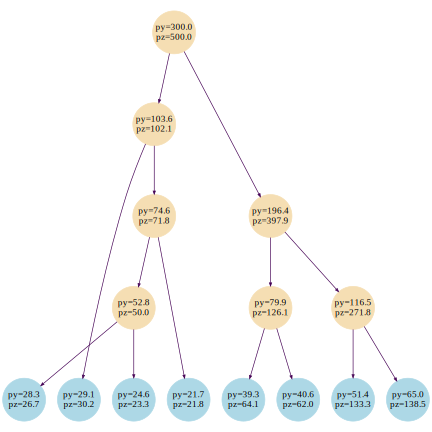

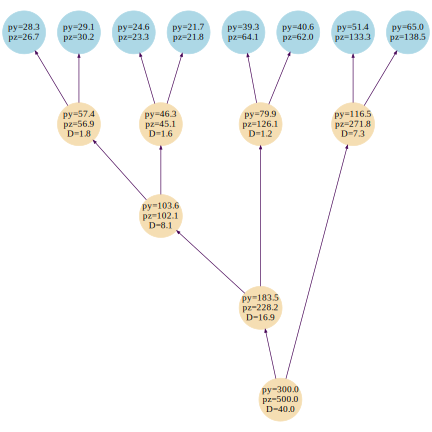

Leaves ordered according to truth jet - kt (top) vs truth (bottom) trees


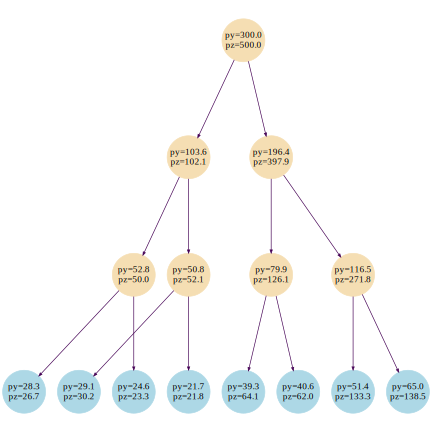

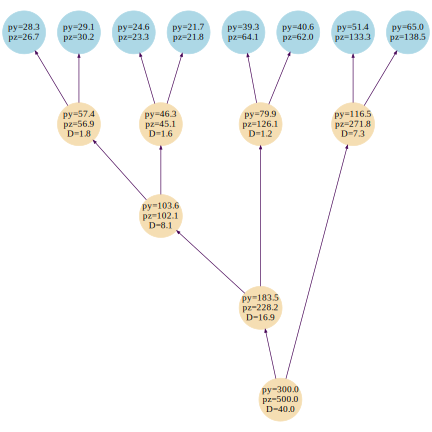

Leaves ordered according to truth jet - CA (top) vs truth (bottom) trees


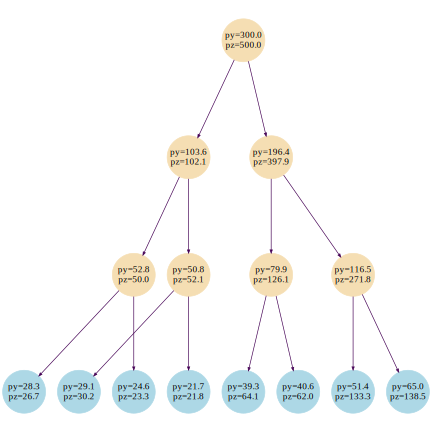

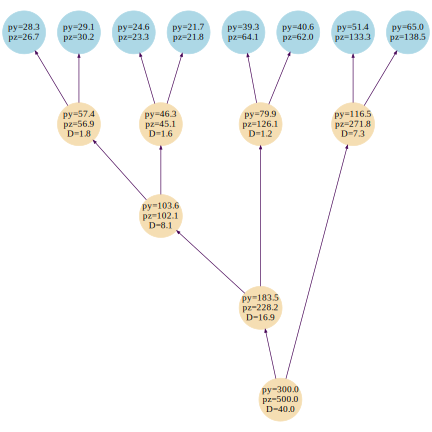

------------------------------------------------------------------------------------------
Leaves ordered in increasing py - anti-kt (top) vs truth (bottom) trees


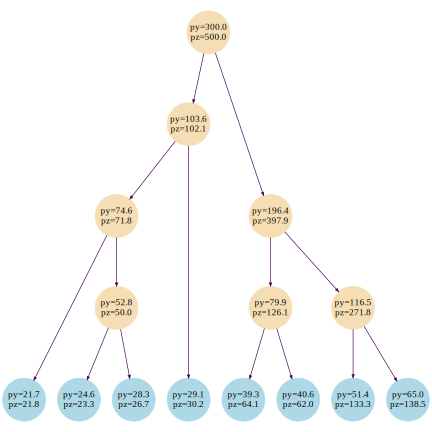

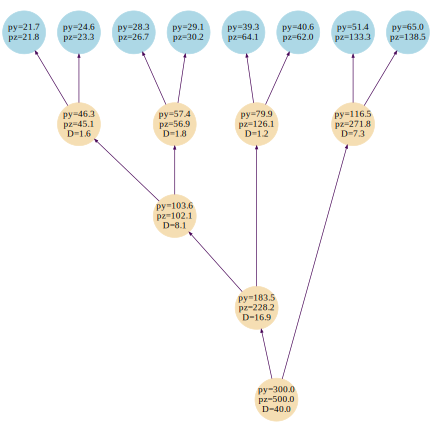

Leaves ordered in increasing py - kt (top) vs truth (bottom) trees


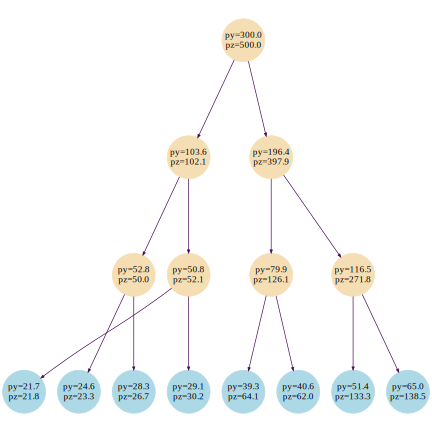

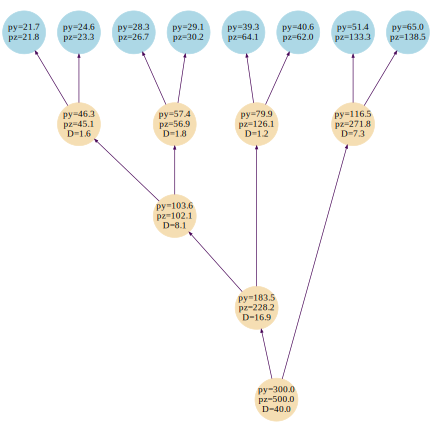

Leaves ordered in increasing py - CA (top) vs truth (bottom) trees


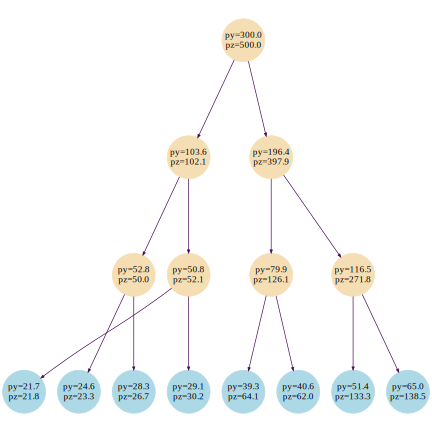

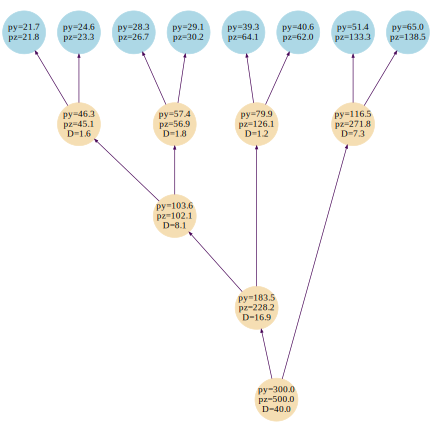

------------------------------------------------------------------------------------------
Leaves ordered according to antikt jet - truth (top) vs antikt (bottom) trees


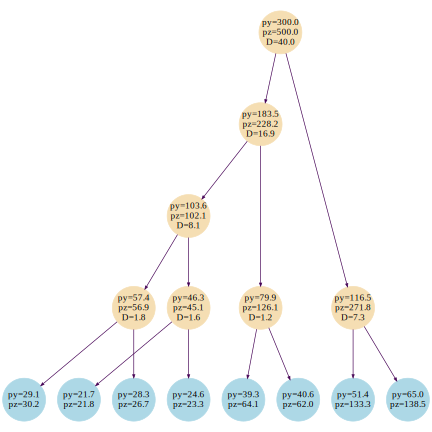

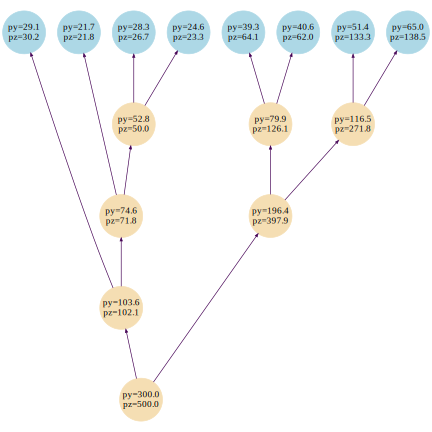

Leaves ordered according to antikt jet - kt (top) vs antikt (bottom) trees


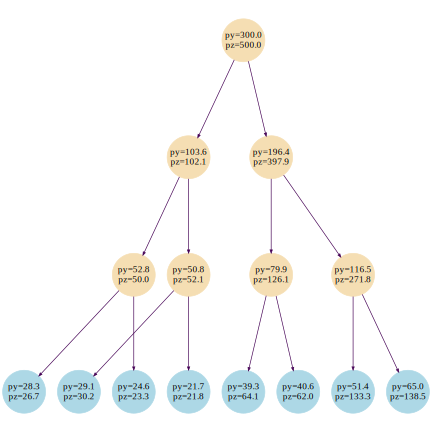

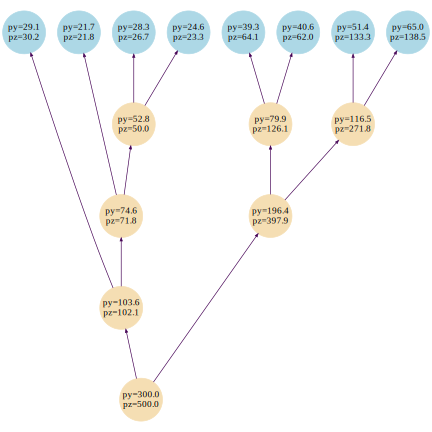

Leaves ordered according to antikt jet - CA (top) vs antikt (bottom) trees


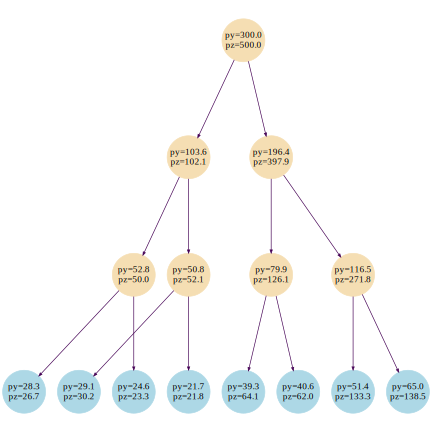

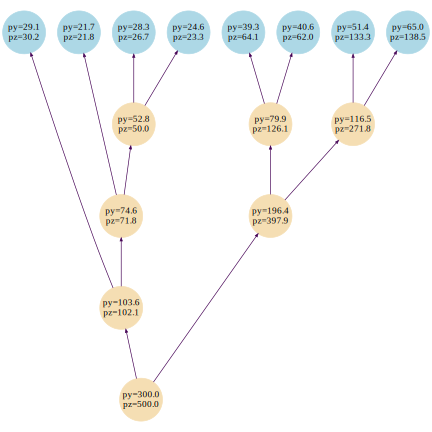

------------------------------------------------------------------------------------------
Leaves with different order - anti-kt (top) vs truth (bottom) trees


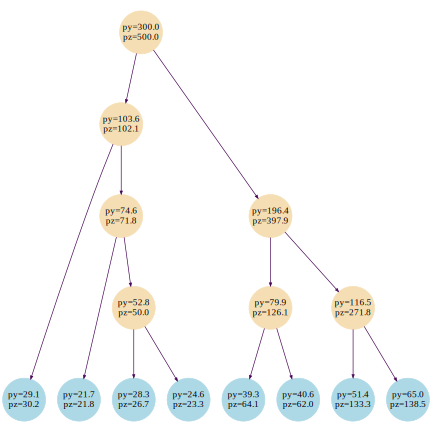

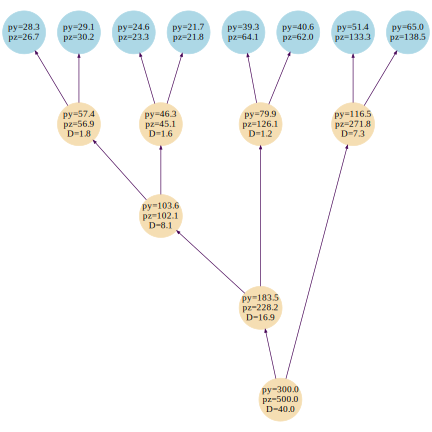

Leaves with different order - kt (top) vs truth (bottom) trees


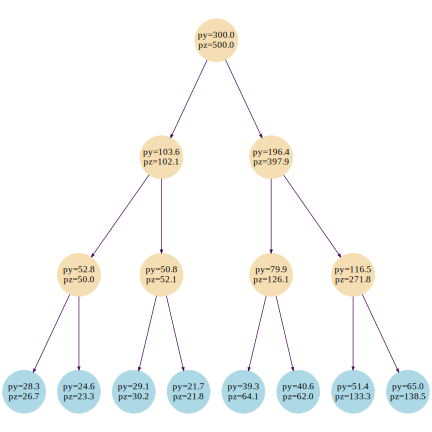

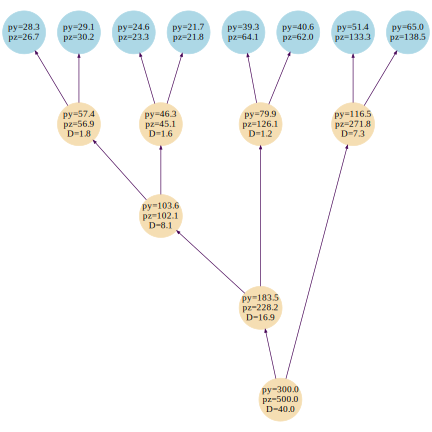

Leaves with different order - CA (top) vs truth (bottom) trees


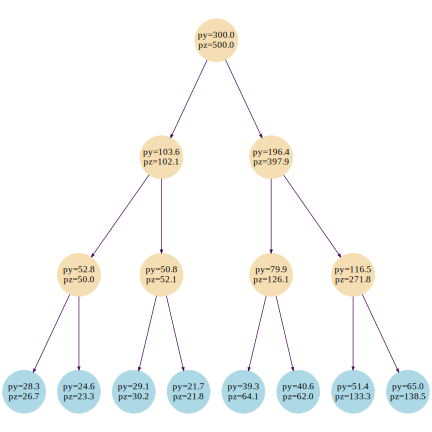

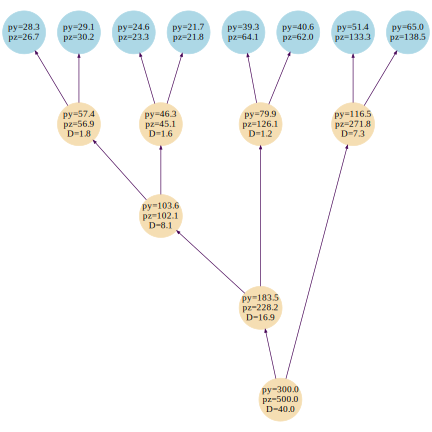

In [744]:
input_jet='tree_19_truth'
node_id_antikt, node_id_kt, node_id_CA , linkage_list_antikt, linkage_list_kt, linkage_list_CA= recluster_all(input_jet)
visualize_all(input_jet, order='truth')
visualize_all(input_jet, order='py')
visualize_all(input_jet, order='antikt')
visualize_all(input_jet, order=None)

In [743]:
# input_jet='tree_15_truth'
# node_id_antikt, node_id_kt, node_id_CA, linkage_list_antikt, linkage_list_kt, linkage_list_CA = recluster_all(input_jet)
# visualize_all(input_jet, order='truth')
# visualize_all(input_jet, order='py')
# visualize_all(input_jet, order=None)

out_filename= data/antikt_tree_31_-1.pkl
out_filename= data/kt_tree_31_1.pkl
out_filename= data/CA_tree_31_0.pkl
------------------------------------------------------------------------------------------
Leaves ordered according to truth jet - anti-kt (top) vs truth (bottom) trees


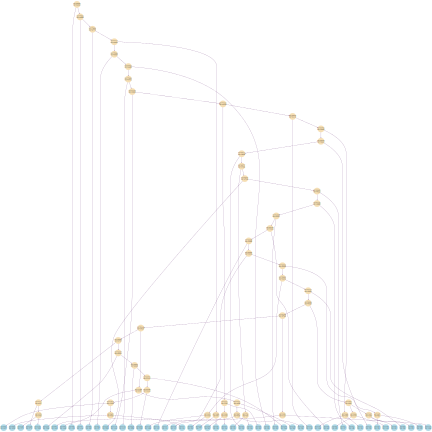

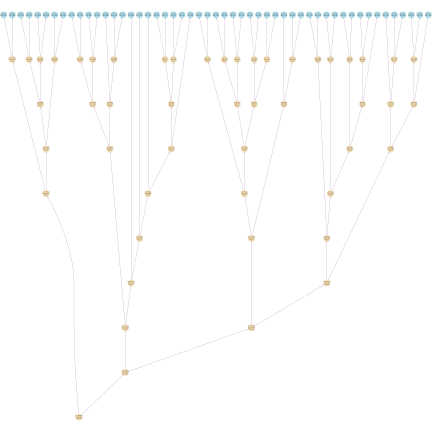

Leaves ordered according to truth jet - kt (top) vs truth (bottom) trees


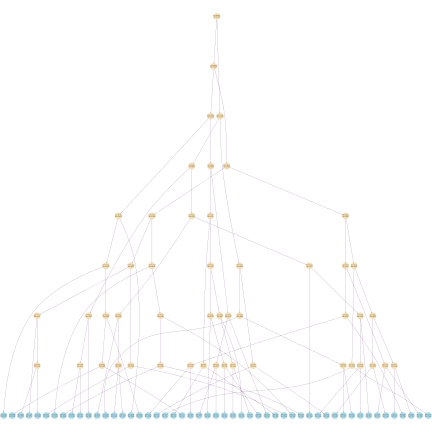

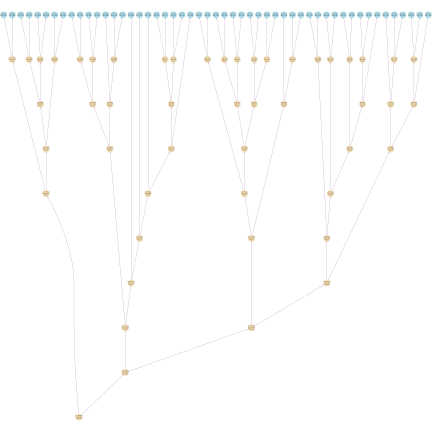

Leaves ordered according to truth jet - CA (top) vs truth (bottom) trees


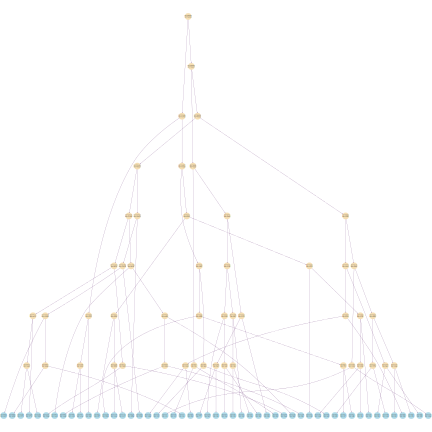

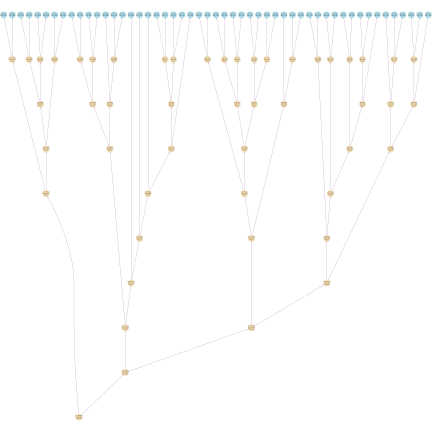

------------------------------------------------------------------------------------------
Leaves ordered in increasing py - anti-kt (top) vs truth (bottom) trees


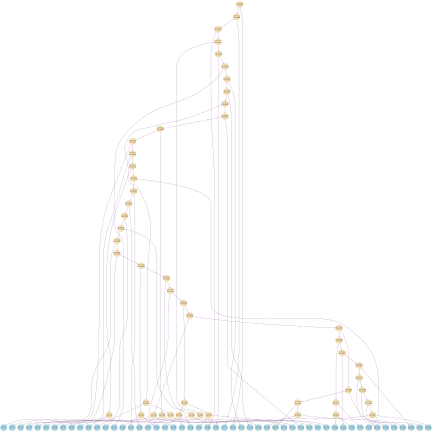

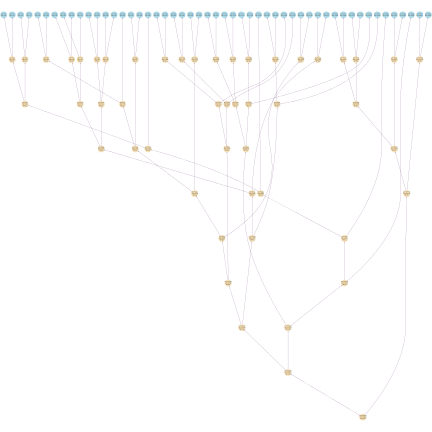

Leaves ordered in increasing py - kt (top) vs truth (bottom) trees


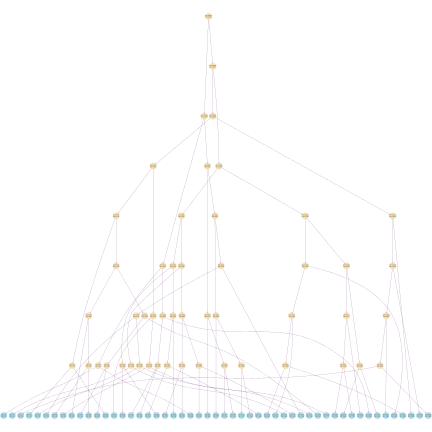

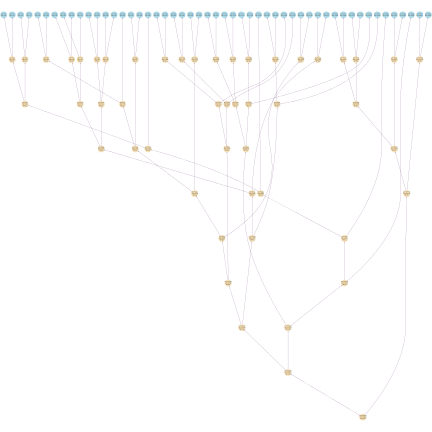

Leaves ordered in increasing py - CA (top) vs truth (bottom) trees


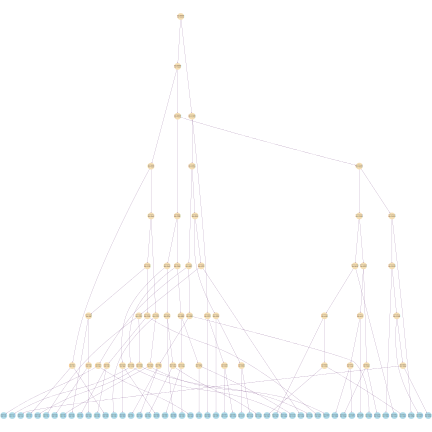

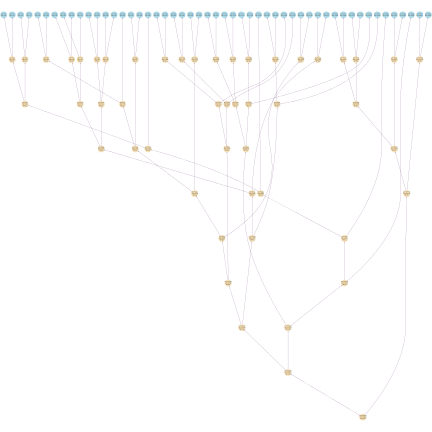

------------------------------------------------------------------------------------------
Leaves ordered according to antikt jet - truth (top) vs antikt (bottom) trees


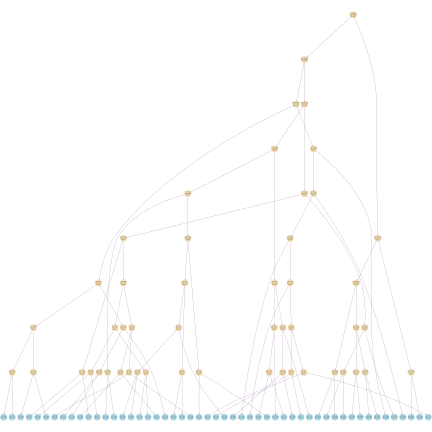

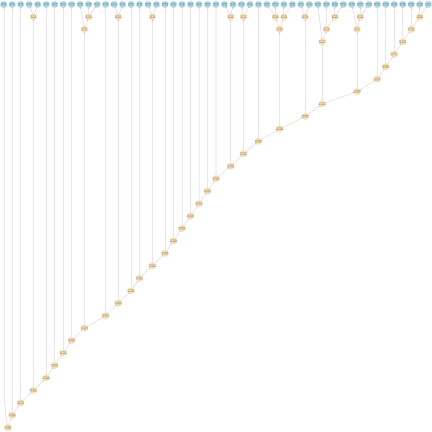

Leaves ordered according to antikt jet - kt (top) vs antikt (bottom) trees


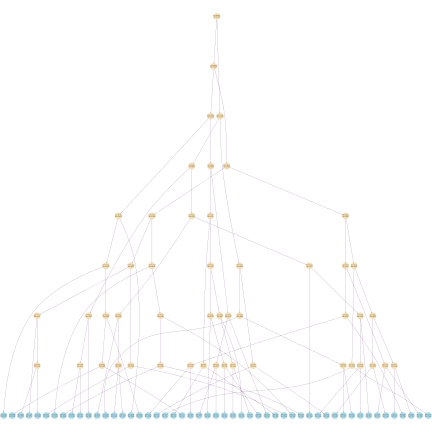

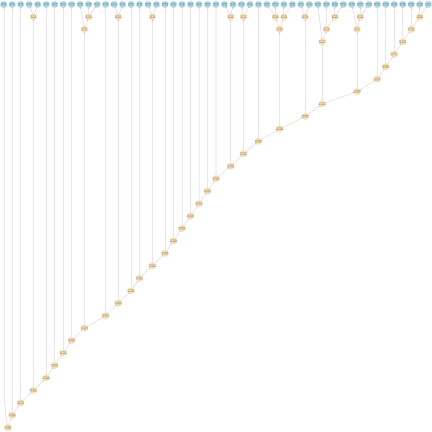

Leaves ordered according to antikt jet - CA (top) vs antikt (bottom) trees


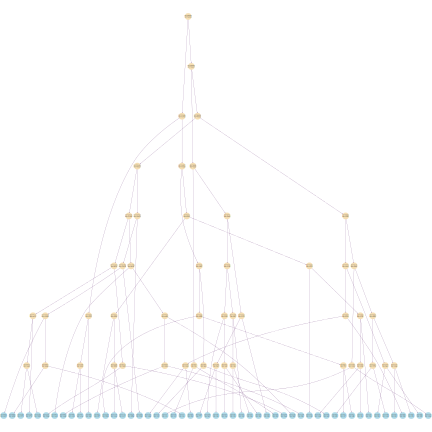

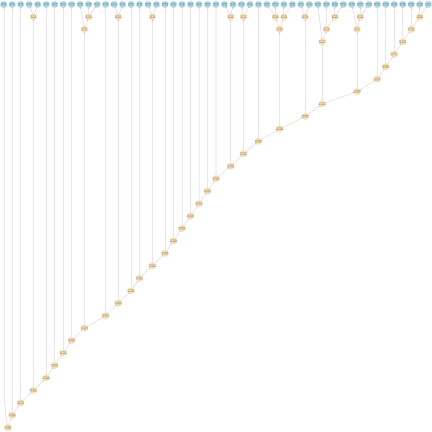

------------------------------------------------------------------------------------------
Leaves with different order - anti-kt (top) vs truth (bottom) trees


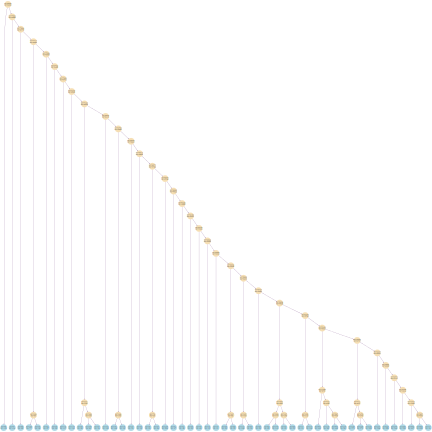

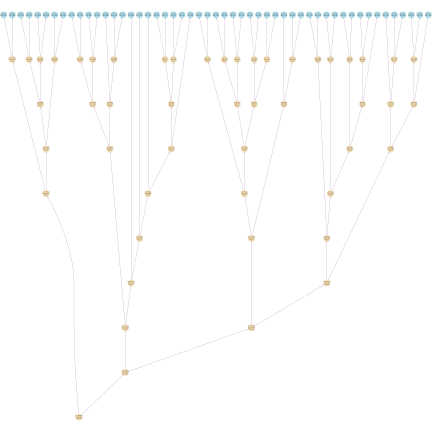

Leaves with different order - kt (top) vs truth (bottom) trees


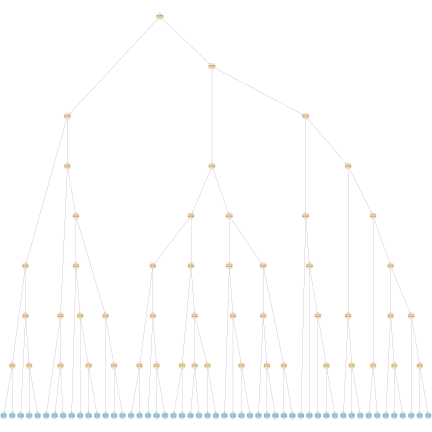

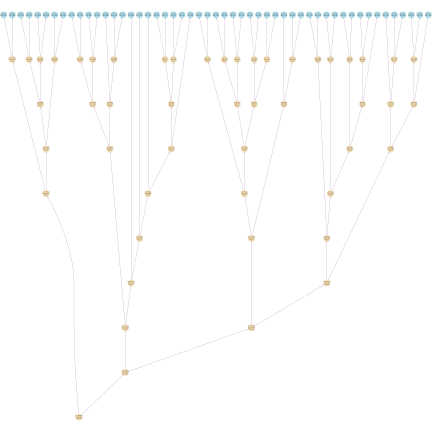

Leaves with different order - CA (top) vs truth (bottom) trees


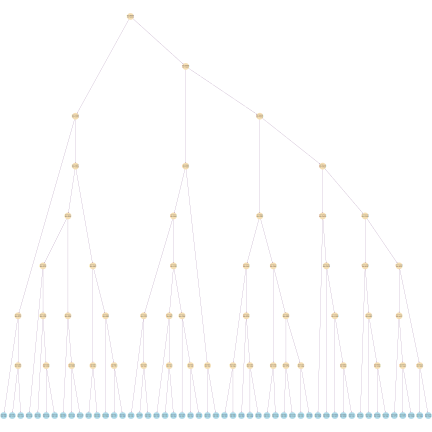

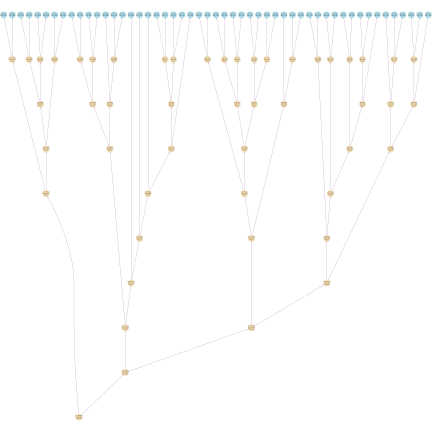

In [784]:
input_jet='tree_31_truth'
node_id_antikt, node_id_kt, node_id_CA, linkage_list_antikt, linkage_list_kt, linkage_list_CA = recluster_all(input_jet)
visualize_all(input_jet, order='truth')
visualize_all(input_jet, order='py')
visualize_all(input_jet, order='antikt')
visualize_all(input_jet, order=None)

In [752]:
# input_jet='antikt_tree_13_truth_-1'
# input_jet_visualize='tree_13_truth'

# node_id_antikt = recluster(input_jet_visualize, alpha=-1)
# node_id_kt = recluster(input_jet, alpha=1)
# node_id_CA = recluster(input_jet, alpha=0)

# # node_id_antikt, node_id_kt, node_id_CA = recluster_all(input_jet)
# visualize_all(input_jet_visualize, order='antikt')


## HEAT CLUSTERMAP VISUALIZATION

In [930]:
def heat_dendrogram(in_jet, algo1=-1,algo2=1, algo3=None, heat_map=True, truth=False, truth_ancestors=None, full_path=False):
#     input_jet = 'antikt_tree_19_truth_-1'

    # Note: the input jet should match the algo1.
    node_id_1, linkage_list_1, Nconst1 ,tree_ancestors_1 = recluster(in_jet, alpha=algo1)
    node_id_2, linkage_list_2, Nconst2, tree_ancestors_2 = recluster(in_jet, alpha=algo2)
    
    
    if heat_map:
    
        if algo3!=None:
            node_id_3, linkage_list_3, Nconst3, tree_ancestors_3 = recluster(in_jet, alpha=algo3)



        if truth:
            
            linkage_list_truth = draw_truth(in_jet)
            
            truth_outers_list , truth_ancestors = runTraverse_jet(in_jet)
              
            level_length=[len(entry) for entry in truth_ancestors]
            max_level=np.max(level_length)

            tree_ancestors_1_array = np.asarray([np.concatenate((truth_ancestors[i],-(i+1)*np.ones((max_level-len(truth_ancestors[i]))))) 
 for i in range(len(truth_ancestors)) ])
    
        else:
            
            level_length=[len(entry) for entry in tree_ancestors_1]
            max_level=np.max(level_length)
            
            tree_ancestors_1_array = np.asarray([np.concatenate((tree_ancestors_1[i],-(i+1)*np.ones((max_level-len(tree_ancestors_1[i]))))) 
     for i in range(len(tree_ancestors_1)) ])


        N_heat=len(tree_ancestors_1_array)
        heat_data=np.zeros((N_heat,N_heat))
        neg_entries = np.sum(np.array(tree_ancestors_1_array) < 0, axis=1)

        
        if full_path:
            for i in range(N_heat):
                for j in range(i+1,N_heat):
        #             print(np.count_nonzero(tree_ancestors_1_array[i]-tree_ancestors_1_array[j]==0))
                    heat_data[i,j]=np.absolute(2*np.count_nonzero((tree_ancestors_1_array[i]-tree_ancestors_1_array[j])==0)-
                                           (2*max_level-(neg_entries[i]+neg_entries[j]))) 
                    heat_data[j,i]=heat_data[i,j]

        else:
            for i in range(N_heat):
                for j in range(i+1,N_heat):
        #             print(np.count_nonzero(tree_ancestors_1_array[i]-tree_ancestors_1_array[j]==0))
                    heat_data[i,j]=np.absolute(np.count_nonzero((tree_ancestors_1_array[i]-tree_ancestors_1_array[j])==0)-
                                           (max_level-np.minimum(neg_entries[i],neg_entries[j])))
                    heat_data[j,i]=heat_data[i,j]

    #     sns.clustermap(heat_data, pivot_kws=None, z_score=None,
    #                    standard_scale=None, figsize=None, cbar_kws=None, row_cluster=False, col_cluster=False, 
    #                    row_linkage=None, col_linkage=None, row_colors=None, col_colors=None, mask=None)
            
        if truth:
            print('---'*20)
            print('truth heat data ----  alpha row: truth -- alpha column:','truth')
            sns.clustermap(heat_data, pivot_kws=None, z_score=None,
                       standard_scale=None, figsize=None, cbar_kws=None, row_cluster=True, col_cluster=True, 
                       row_linkage=linkage_list_truth, col_linkage=linkage_list_truth, row_colors=None, col_colors=None, mask=None)
            plt.show()
            
            
            print('---'*20)
            print('alpha row:',algo1, '-- alpha column:','truth')
            sns.clustermap(heat_data, pivot_kws=None, z_score=None,
                           standard_scale=None, figsize=None, cbar_kws=None, row_cluster=True, col_cluster=True, 
                           row_linkage=linkage_list_1, col_linkage=linkage_list_truth, row_colors=None, col_colors=None, mask=None)
            plt.show()            
            
            
            
            
        else:     
            print('---'*20)
            print('alpha row:',algo1, '-- alpha column:',algo1)
            sns.clustermap(heat_data, pivot_kws=None, z_score=None,
                           standard_scale=None, figsize=None, cbar_kws=None, row_cluster=True, col_cluster=True, 
                           row_linkage=linkage_list_1, col_linkage=linkage_list_1, row_colors=None, col_colors=None, mask=None)
            plt.show()

            print('---'*20)
            print('alpha row:',algo2, '-- alpha column:',algo1)
            sns.clustermap(heat_data, pivot_kws=None, z_score=None,
                           standard_scale=None, figsize=None, cbar_kws=None, row_cluster=True, col_cluster=True, 
                           row_linkage=linkage_list_2, col_linkage=linkage_list_1, row_colors=None, col_colors=None, mask=None)
            plt.show()


            if algo3!=None:

                print('---'*20)
                print('alpha row:',algo3, '-- alpha column:',algo1)
                sns.clustermap(heat_data, pivot_kws=None, z_score=None,
                           standard_scale=None, figsize=None, cbar_kws=None, row_cluster=True, col_cluster=True, 
                           row_linkage=linkage_list_3, col_linkage=linkage_list_1, row_colors=None, col_colors=None, mask=None)
                plt.show()


#         return heat_data

In [756]:
def visualize_all_trees(in_jet,order=None):
    
    '''
    Recluster an input jet dictionary into kt, anti-kt and CA trees and visualize them.
    
    node_id_... is a list of the leaves in the order that appearn when we traverse a (anti-kt,kt,CA) tree and the indices are the ones 
    from the truth tree leaves that go from 1 to NConst. We take the order in which the leaves appear when traversing the truth tree
    as increasing from 0 to NConst 
    '''
    node_id_antikt, linkage_list_antikt, Nconst,tt = recluster(in_jet, alpha=-1)
    node_id_kt, linkage_list_kt,Nconst,tt = recluster(in_jet, alpha=1)
    node_id_CA, linkage_list_CA,Nconst,tt = recluster(in_jet, alpha=0)
    
    visualize_all(input_jet, order=order)
    
#     return node_id_antikt, node_id_kt, node_id_CA

out_filename= data/antikt_tree_19_-1.pkl
out_filename= data/kt_tree_19_1.pkl
------------------------------------------------------------
truth heat data ----  alpha row: truth -- alpha column: truth


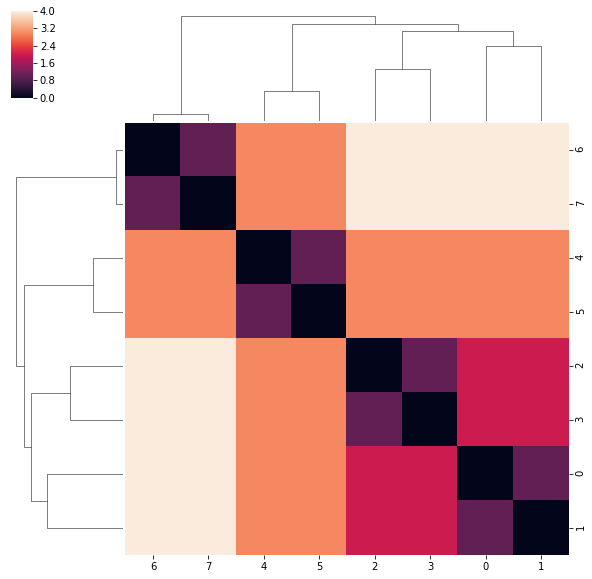

------------------------------------------------------------
alpha row: -1 -- alpha column: truth


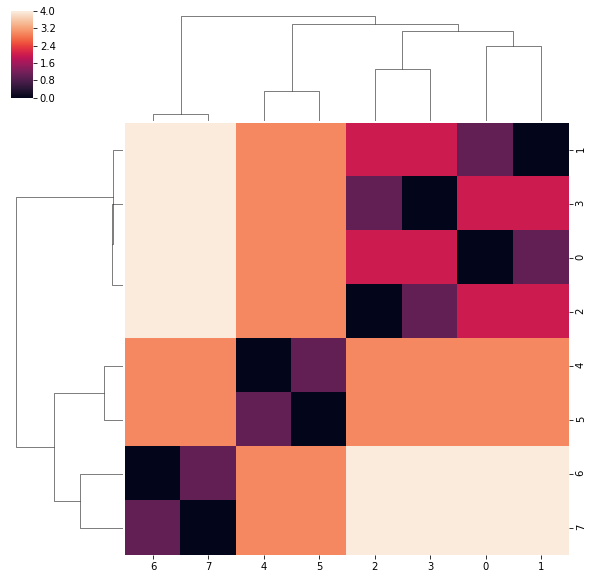

In [931]:
heat_dendrogram('tree_19_truth', truth=True)

out_filename= data/antikt_tree_19_-1.pkl
out_filename= data/kt_tree_19_1.pkl
out_filename= data/CA_tree_19_0.pkl
------------------------------------------------------------------------------------------
Leaves ordered according to truth jet - anti-kt (top) vs truth (bottom) trees


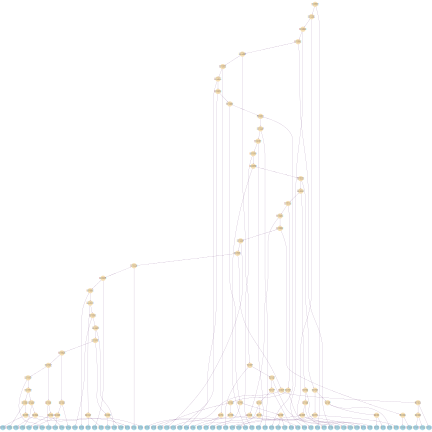

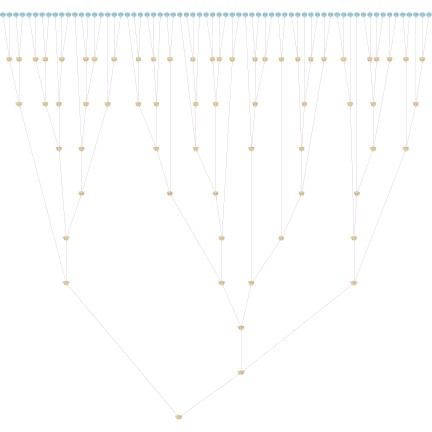

Leaves ordered according to truth jet - kt (top) vs truth (bottom) trees


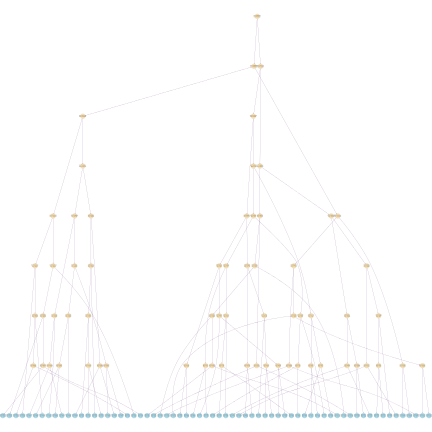

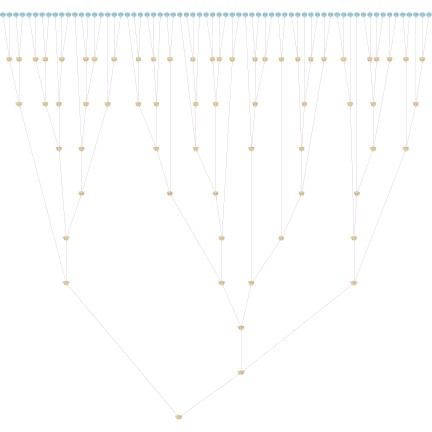

Leaves ordered according to truth jet - CA (top) vs truth (bottom) trees


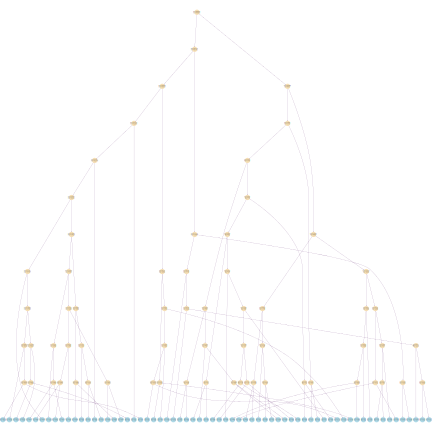

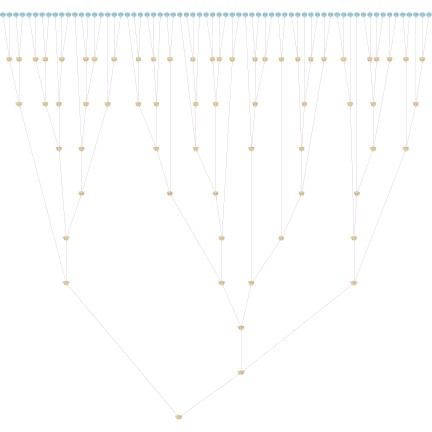

In [757]:
visualize_all_trees('tree_19_truth',order='truth')

In [904]:
# visualize_all_trees('antikt_tree_19_-1',order='antikt')

### SMALL TREE

### 2D visualizations

#### Distance matrix based on the anti-kt tree (Small tree)

out_filename= data/antikt_tree_19_-1.pkl
out_filename= data/kt_tree_19_1.pkl
------------------------------------------------------------
truth heat data ----  alpha row: truth -- alpha column: truth


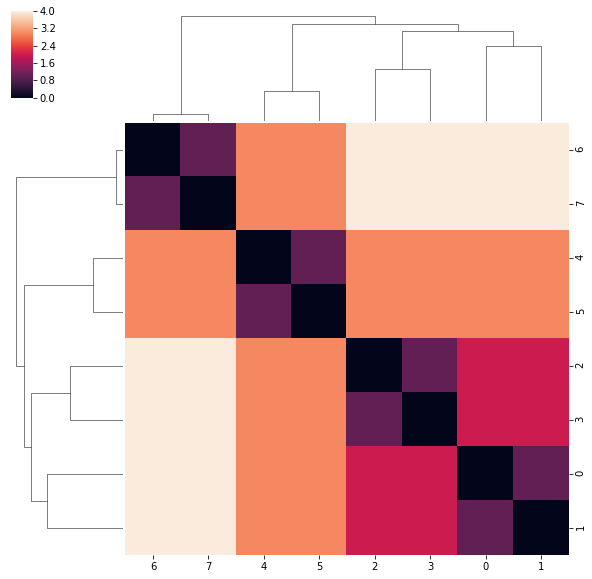

------------------------------------------------------------
alpha row: -1 -- alpha column: truth


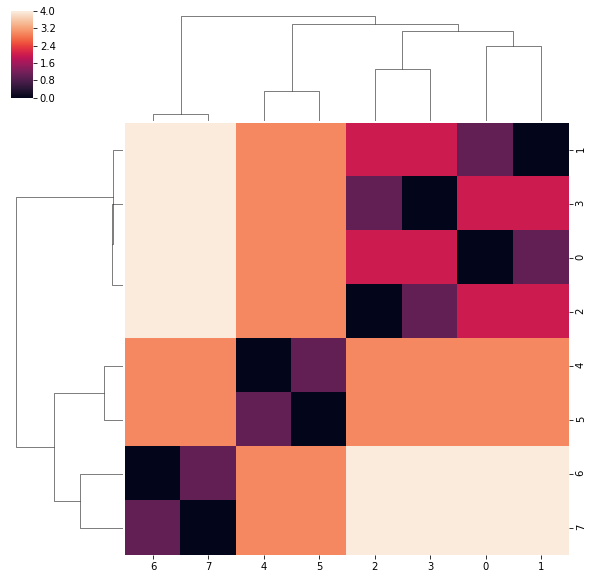

In [932]:
heat_dendrogram('tree_19_truth', truth=True)

out_filename= data/antikt_tree_19_-1.pkl
out_filename= data/kt_tree_19_1.pkl
out_filename= data/CA_tree_19_0.pkl
------------------------------------------------------------
alpha row: -1 -- alpha column: -1


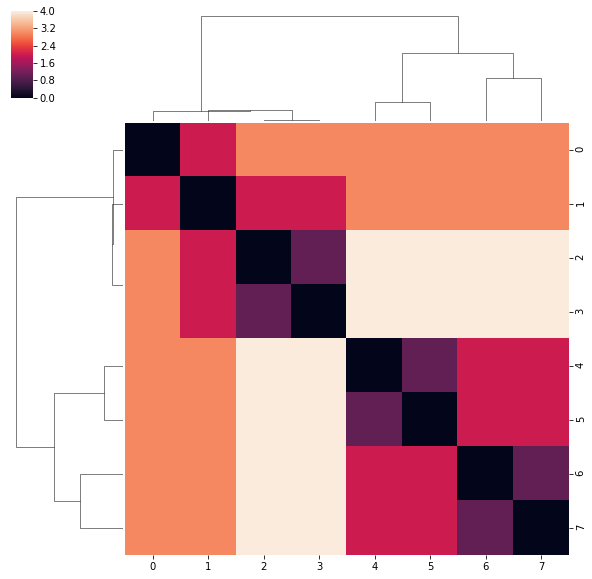

------------------------------------------------------------
alpha row: 1 -- alpha column: -1


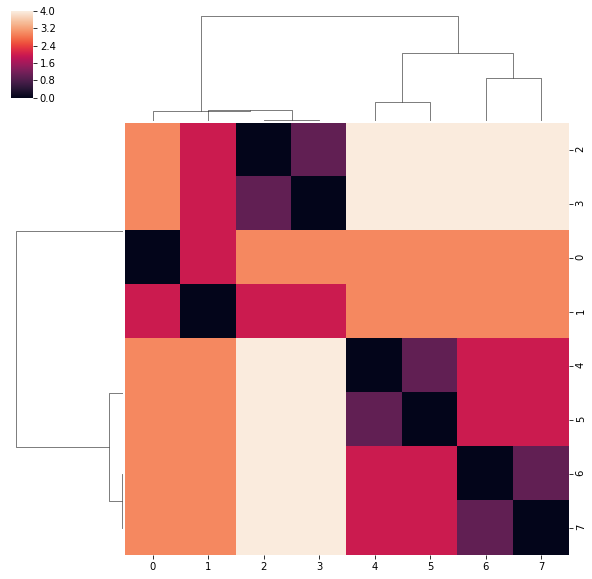

------------------------------------------------------------
alpha row: 0 -- alpha column: -1


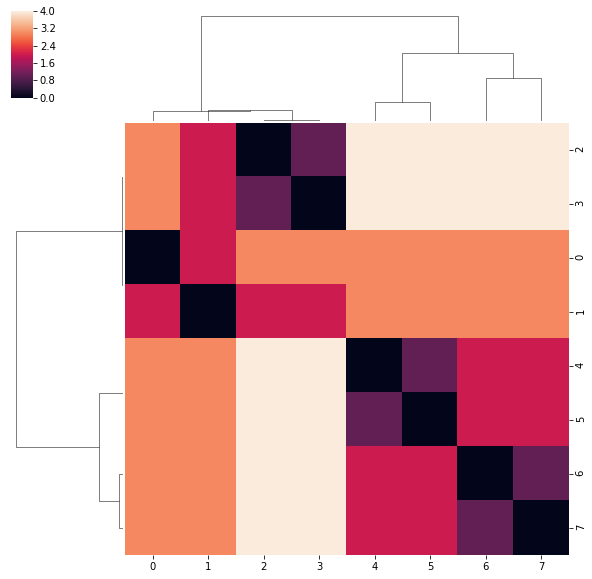

In [933]:

# heat_dendrogram('tree_19_truth', heat_map=False)
heat_dendrogram('antikt_tree_19_-1', algo1=-1,algo2=1, algo3=0)

out_filename= data/antikt_tree_19_-1.pkl
out_filename= data/kt_tree_19_1.pkl
out_filename= data/CA_tree_19_0.pkl
------------------------------------------------------------
alpha row: -1 -- alpha column: -1


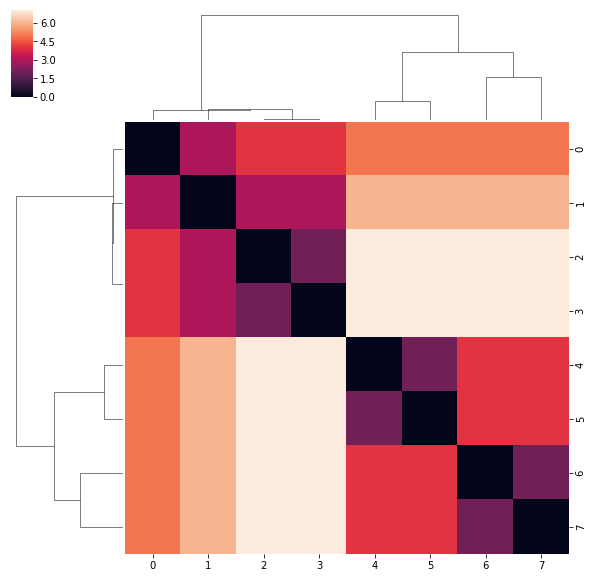

------------------------------------------------------------
alpha row: 1 -- alpha column: -1


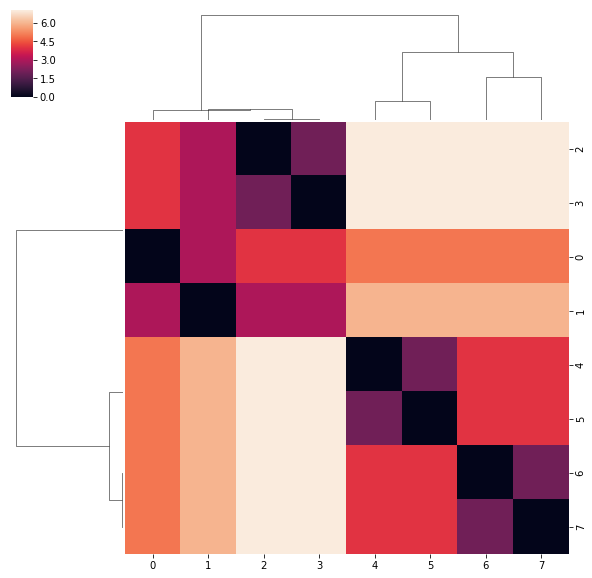

------------------------------------------------------------
alpha row: 0 -- alpha column: -1


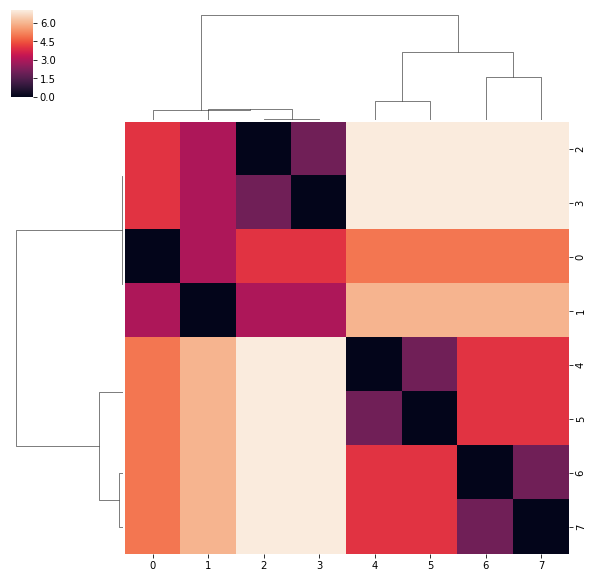

In [934]:
heat_dendrogram('antikt_tree_19_-1', algo1=-1,algo2=1, algo3=0, full_path=True)

#### Distance matrix based on the kt tree (Small tree)

out_filename= data/kt_tree_19_1.pkl
out_filename= data/antikt_tree_19_-1.pkl
out_filename= data/CA_tree_19_0.pkl
------------------------------------------------------------
alpha row: 1 -- alpha column: 1


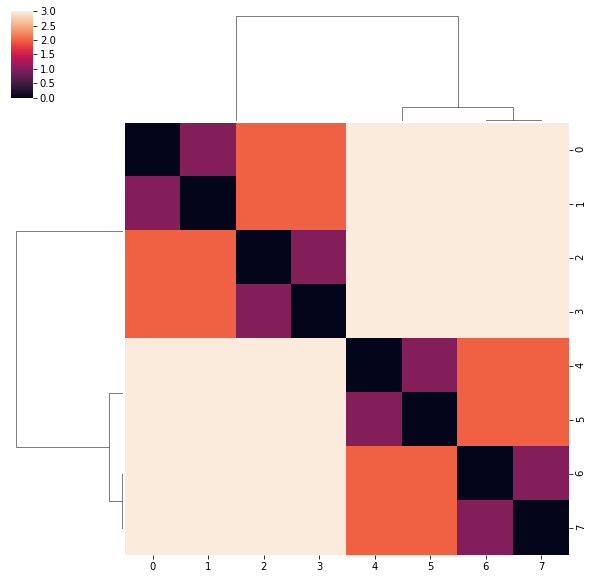

------------------------------------------------------------
alpha row: -1 -- alpha column: 1


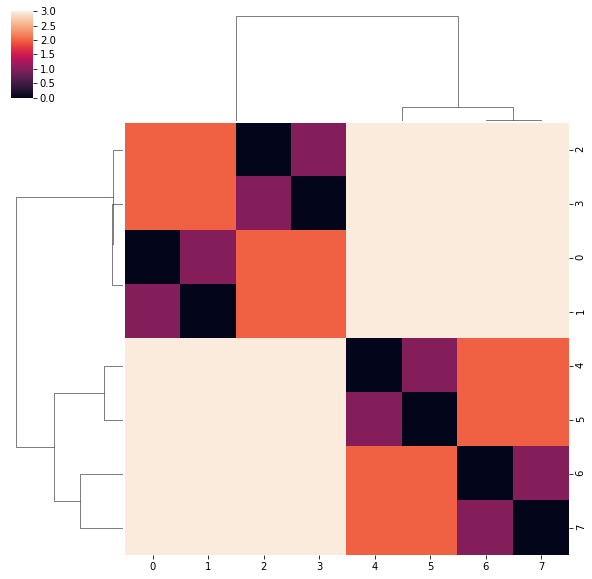

------------------------------------------------------------
alpha row: 0 -- alpha column: 1


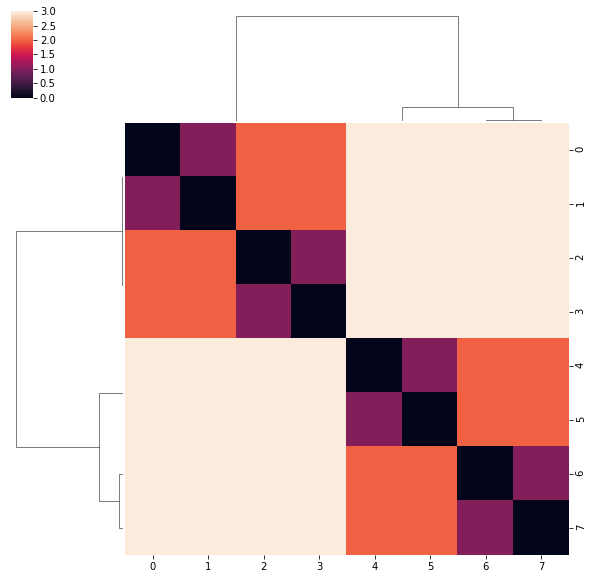

In [935]:
# heat_dendrogram('tree_19_truth', heat_map=False)
heat_dendrogram('kt_tree_19_1', algo1=1,algo2=-1, algo3=0)

### LONG TREE

#### Distance matrix based on the anti-kt tree (long tree)

out_filename= data/antikt_tree_31_-1.pkl
out_filename= data/kt_tree_31_1.pkl
out_filename= data/CA_tree_31_0.pkl
------------------------------------------------------------
truth heat data ----  alpha row: truth -- alpha column: truth


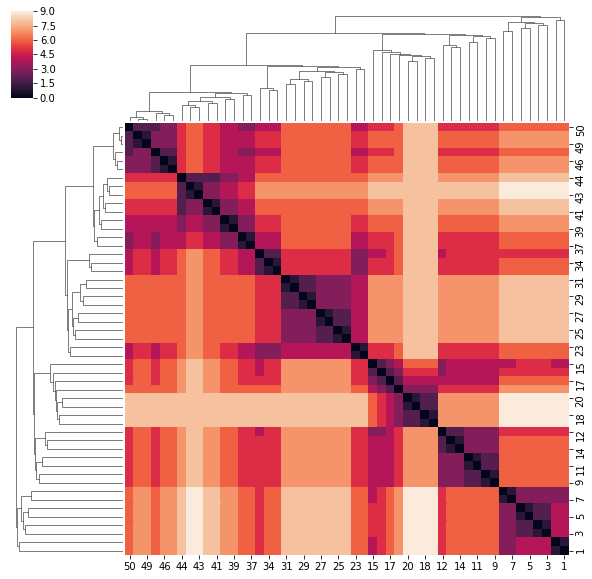

------------------------------------------------------------
alpha row: -1 -- alpha column: truth


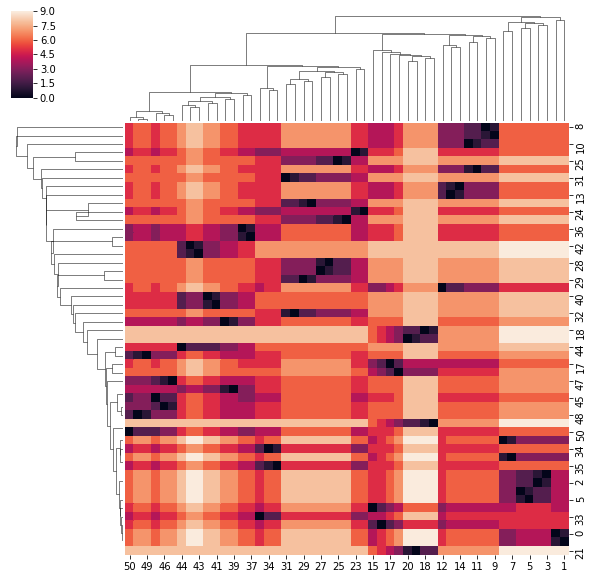

In [936]:
heat_dendrogram('tree_31_truth', truth=True, algo3=0)

out_filename= data/antikt_tree_31_-1.pkl
out_filename= data/kt_tree_31_1.pkl
out_filename= data/CA_tree_31_0.pkl
------------------------------------------------------------
alpha row: -1 -- alpha column: -1


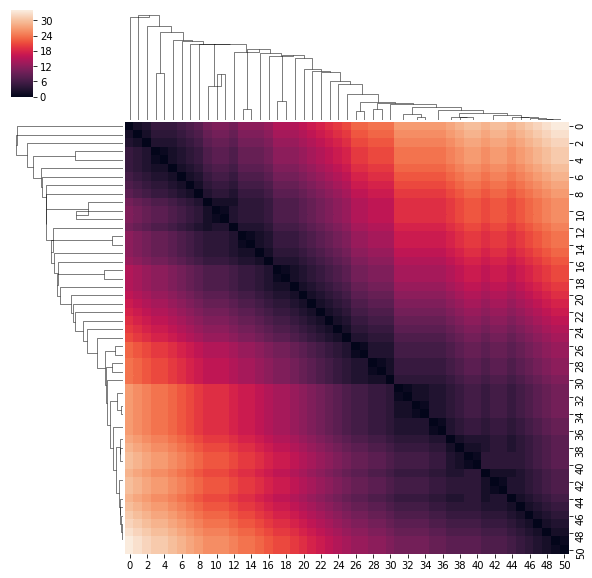

------------------------------------------------------------
alpha row: 1 -- alpha column: -1


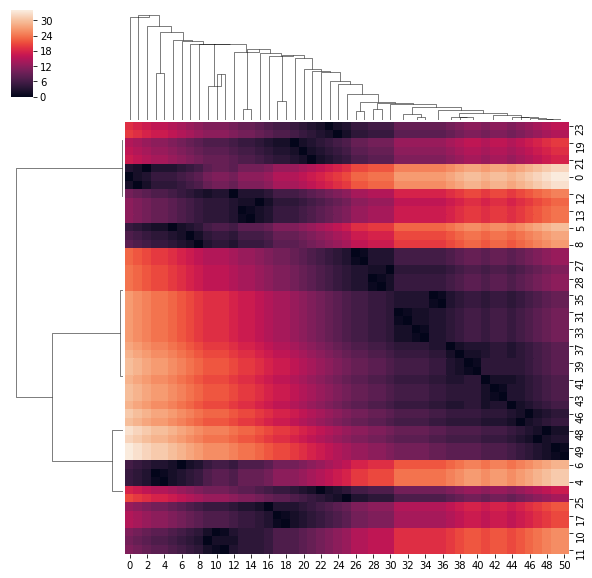

------------------------------------------------------------
alpha row: 0 -- alpha column: -1


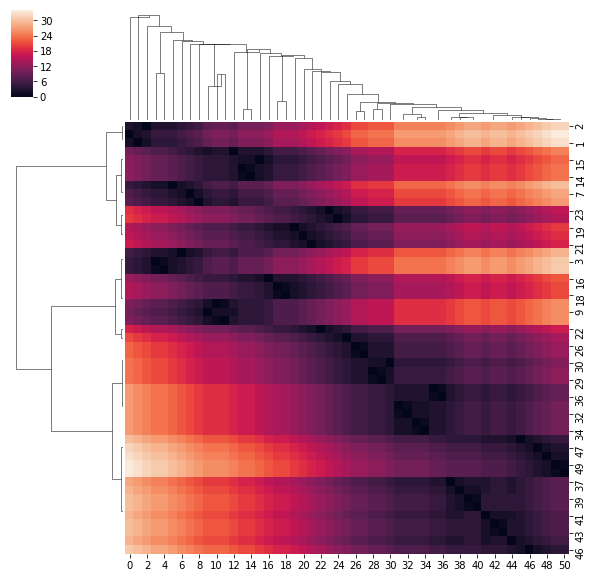

In [937]:
# heat_dendrogram('tree_27_truth', heat_map=False, algo3=0)
heat_dendrogram('antikt_tree_31_-1', algo1=-1,algo2=1, algo3=0)

In [766]:
# heat_dendrogram('tree_15_truth', heat_map=False, algo3=0)
# heat_dendrogram('antikt_tree_15_-1', algo1=-1,algo2=1, algo3=0)

#### Distance matrix based on the kt tree (long tree)

out_filename= data/kt_tree_31_1.pkl
out_filename= data/antikt_tree_31_-1.pkl
out_filename= data/CA_tree_31_0.pkl
------------------------------------------------------------
alpha row: 1 -- alpha column: 1


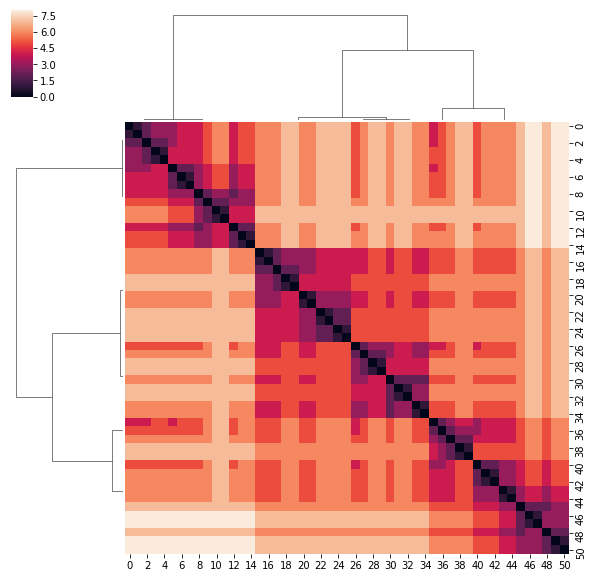

------------------------------------------------------------
alpha row: -1 -- alpha column: 1


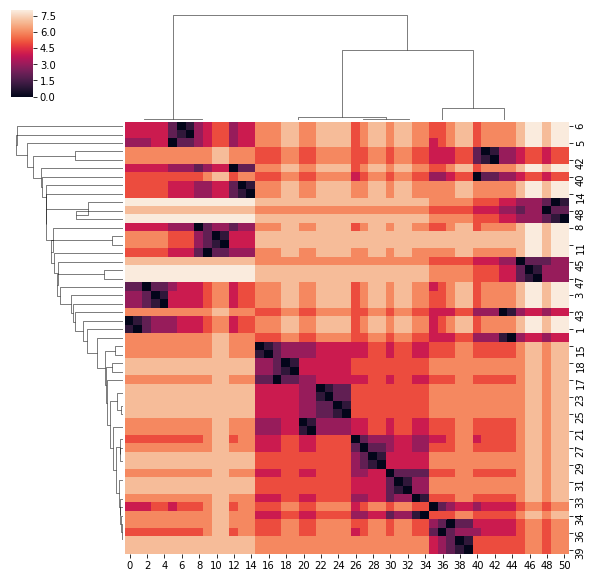

------------------------------------------------------------
alpha row: 0 -- alpha column: 1


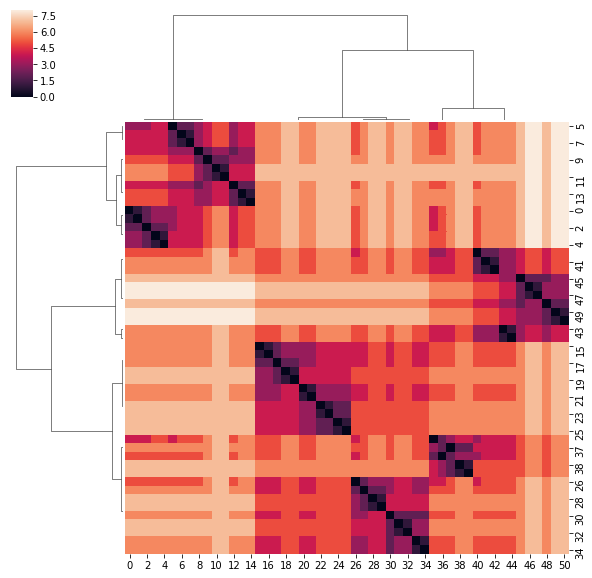

In [938]:
# heat_dendrogram('tree_27_truth', heat_map=False, algo3=0)
heat_dendrogram('kt_tree_31_1', algo1=1,algo2=-1, algo3=0)

In [ ]:
# heat_dendrogram('tree_15_truth', heat_map=False, algo3=0)
# heat_dendrogram('kt_tree_15_1', algo1=1,algo2=-1, algo3=0)

In [11]:
# const_list , dij_history, raw_tree, idx,jet_content, root_node, Nconst = kt_algo(jet_const)

#### Number of steps that connect each pair of nodes

out_filename= data/antikt_tree_31_-1.pkl
out_filename= data/kt_tree_31_1.pkl
out_filename= data/CA_tree_31_0.pkl
------------------------------------------------------------
truth heat data ----  alpha row: truth -- alpha column: truth


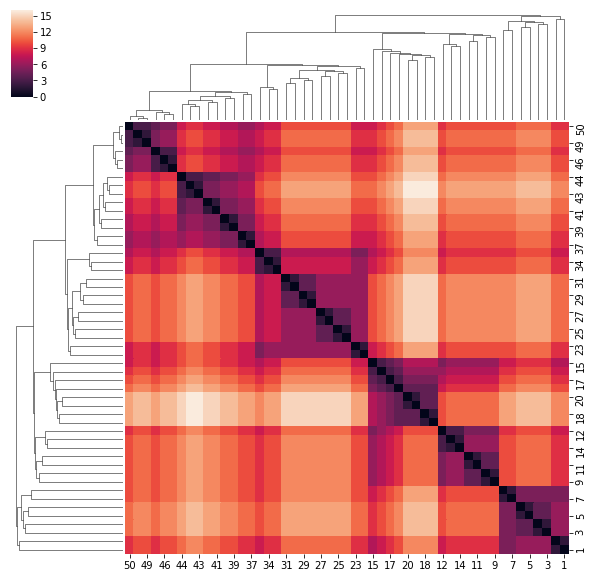

------------------------------------------------------------
alpha row: -1 -- alpha column: truth


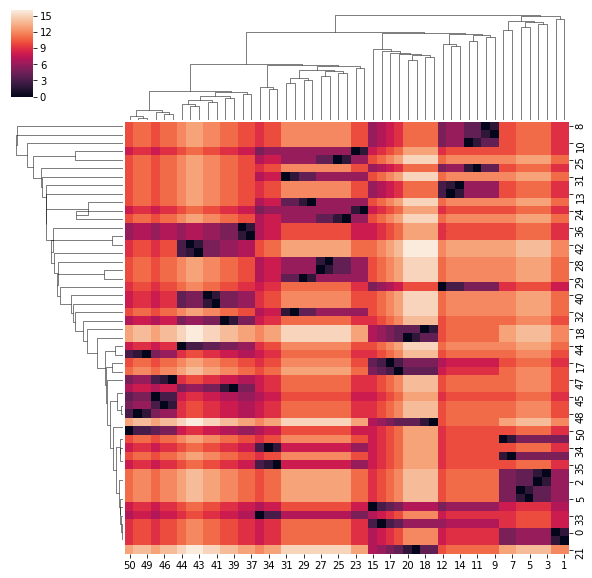

In [941]:
heat_dendrogram('tree_31_truth', truth=True, algo3=0, full_path=True)

out_filename= data/antikt_tree_31_-1.pkl
out_filename= data/kt_tree_31_1.pkl
out_filename= data/CA_tree_31_0.pkl
------------------------------------------------------------
alpha row: -1 -- alpha column: -1


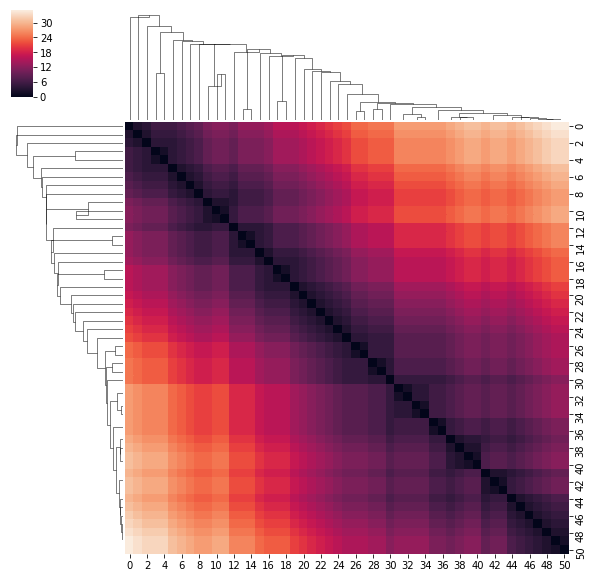

------------------------------------------------------------
alpha row: 1 -- alpha column: -1


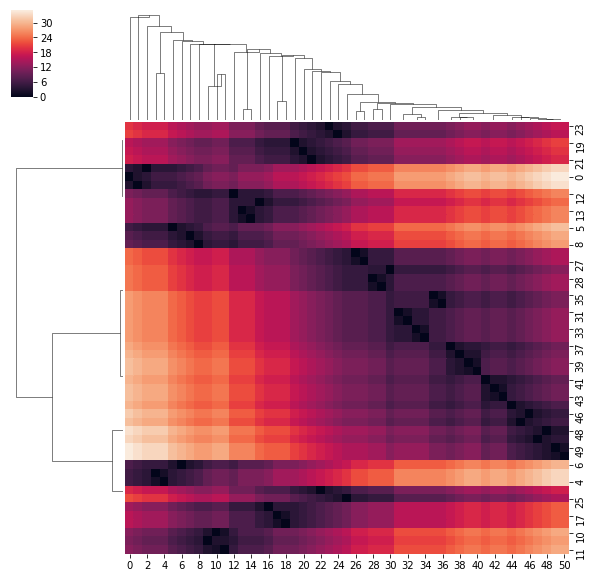

------------------------------------------------------------
alpha row: 0 -- alpha column: -1


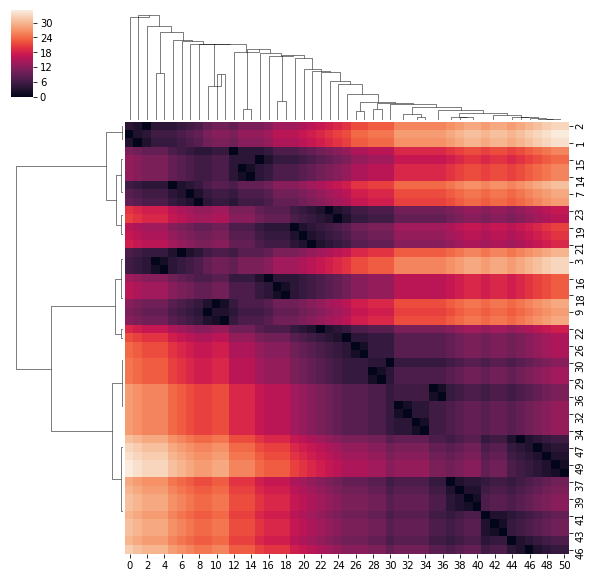

In [939]:
heat_dendrogram('antikt_tree_31_-1', algo1=-1,algo2=1, algo3=0, full_path=True)

out_filename= data/kt_tree_31_1.pkl
out_filename= data/antikt_tree_31_-1.pkl
out_filename= data/CA_tree_31_0.pkl
------------------------------------------------------------
alpha row: 1 -- alpha column: 1


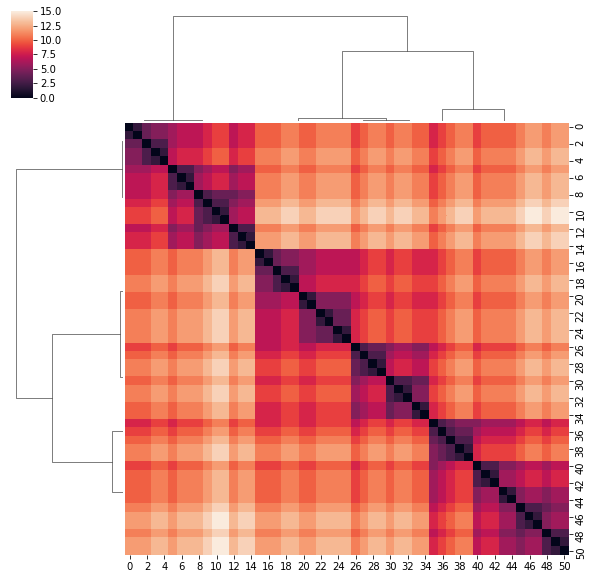

------------------------------------------------------------
alpha row: -1 -- alpha column: 1


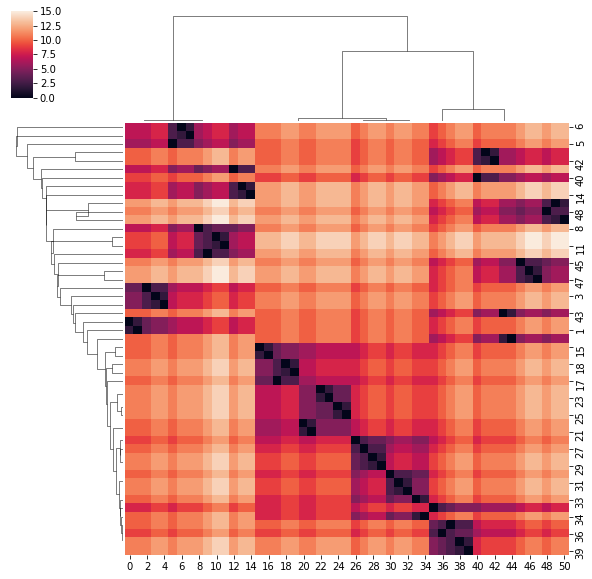

------------------------------------------------------------
alpha row: 0 -- alpha column: 1


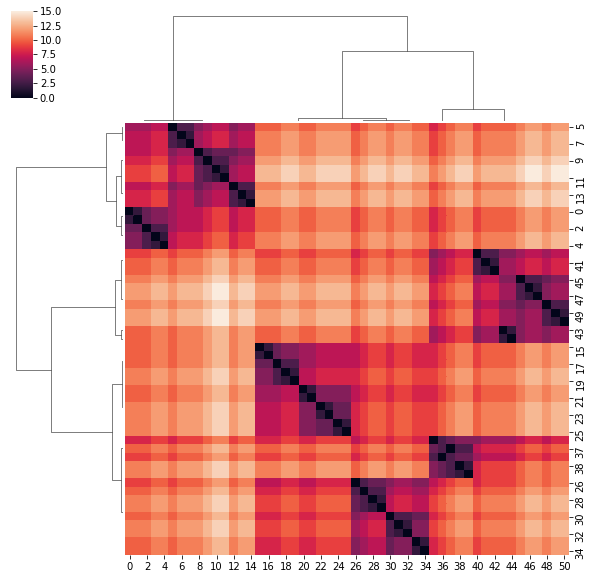

In [940]:
heat_dendrogram('kt_tree_31_1', algo1=1,algo2=-1, algo3=0, full_path=True)